In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
from scipy import signal, stats

import IPython.display
import cmocean as cm
import sys, os, glob
import warnings
warnings.simplefilter("ignore") 

from IPython.display import Image

from dask.distributed import Client

from matplotlib.patches import Rectangle

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rcParams['font.size'] = 15
letlab = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)',
          '(i)','(j)','(k)','(l)','(m)','(n)','(o)','(p)',
          '(q)','(r)','(s)','(t)','(u)','(v)','(w)','(x)',
          '(y)','(z)']

In [3]:
# Load workers:
client = Client(n_workers=28)
client

<Client: 'tcp://127.0.0.1:34669' processes=28 threads=28, memory=125.20 GiB>

# Load datasets and utilities

In [4]:
base = '/g/data/e14/rmh561/croco/'
base_data = base + 'archive/'
base_analysis = base + '/analysis/'

os.chdir(base_analysis + 'PAC12_75_cpl')
sys.path.append(base_analysis + 'PAC12_75_cpl/Processing_Scripts')
sys.path.append(base_analysis + 'PAC12_75_cpl/Processing_Scripts/Tracer_balance_code_LMaillard_v2')

In [5]:
# Load custom scripts/tools:
import pac12_tools as ptools
import R_tools_fort as ftools

In [6]:
# Reload (if needed):
import importlib
importlib.reload(ptools)

<module 'pac12_tools' from '/g/data/e14/rmh561/croco//analysis/PAC12_75_cpl/Processing_Scripts/pac12_tools.py'>

In [19]:
# define runs:
expdict = {
# CROCO-WRF runs:
        'CROCO-WRF Control-E1':{'exp':'PAC12_75_cpl','expn':'exp02','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF Control-E2':{'exp':'PAC12_75_cpl','expn':'exp08','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF Control-E3':{'exp':'PAC12_75_cpl','expn':'exp09','CPL':True,'TSoffset': 2014.,'TIWoutput':True}
#        ,'CROCO-WRF Control-E4':{'exp':'PAC12_75_cpl','expn':'exp10','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF Control-E5':{'exp':'PAC12_75_cpl','expn':'exp11','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
        ,'CROCO-WRF NoTFB-E1':{'exp':'PAC12_75_cpl','expn':'exp12','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF NoTFB-E2':{'exp':'PAC12_75_cpl','expn':'exp14','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF NoTFB-E3':{'exp':'PAC12_75_cpl','expn':'exp17','CPL':True,'TSoffset': 2014.,'TIWoutput':True}
#        ,'CROCO-WRF NoTFB-E4':{'exp':'PAC12_75_cpl','expn':'exp20','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF NoTFB-E5':{'exp':'PAC12_75_cpl','expn':'exp23','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
        ,'CROCO-WRF NoMesoCFB-E1':{'exp':'PAC12_75_cpl','expn':'exp13','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF NoMesoCFB-E2':{'exp':'PAC12_75_cpl','expn':'exp15','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF NoMesoCFB-E3':{'exp':'PAC12_75_cpl','expn':'exp18','CPL':True,'TSoffset': 2014.,'TIWoutput':True}
#        ,'CROCO-WRF NoMesoCFB-E4':{'exp':'PAC12_75_cpl','expn':'exp21','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF NoMesoCFB-E5':{'exp':'PAC12_75_cpl','expn':'exp24','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF NoCFB-E1':{'exp':'PAC12_75_cpl','expn':'exp26','CPL':True,'TSoffset': 2014.,'TIWoutput':True}
#        ,'CROCO-WRF NoCFB-E2':{'exp':'PAC12_75_cpl','expn':'exp27','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF NoCFB-E3':{'exp':'PAC12_75_cpl','expn':'exp28','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF NoCFB-E4':{'exp':'PAC12_75_cpl','expn':'exp29','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO-WRF NoCFB-E5':{'exp':'PAC12_75_cpl','expn':'exp30','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
# CROCO-only runs:
#         ,'CROCO Control':{'exp':'PAC12_75','expn':'exp11','CPL':False,'TSoffset': 2014.,'TIWoutput':False}
#        ,'CROCO PP81':{'exp':'PAC12_75','expn':'exp12','CPL': False,'TSoffset': 2014.,'TIWoutput':False}
          }
cont = 'CROCO-WRF Control-E1'
eL = 5

In [20]:
# Load CROCO data:
data_typs = ['mon','day','mon_hp','mon_TIWhp']
dropvars = {'mon':['omega','u_sq','v_sq','salt_sq','AKv'],
            'day':[],
            '3day':[],
            'ts_3day':[],
            'mon_hp':[],
            'mon_TIWhp':[],
            'mon_TIWhpstd':[]}
dropyears = ['2014']
#dropyears = ['2015','2016','2017','2018']
TIWoutonly = False #True

gfiles = glob.glob(base_data + expdict['CROCO-WRF Control-E1']['exp'] + '/' + expdict['CROCO-WRF Control-E1']['exp'] + '_' + expdict['CROCO-WRF Control-E1']['expn'] + '/*/croco_out_grd.nc')
grd = xr.open_dataset(gfiles[0],chunks={'y_rho':100,'x_rho':100})

data = {}
for nam in expdict.keys():
    data[nam] = {}
    if ((not TIWoutonly) or (TIWoutonly and expdict[nam]['TIWoutput'])):
        exp = expdict[nam]['exp']
        expn = expdict[nam]['expn']
        for typ in data_typs:   
            try:
                files = sorted(glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/croco_out_' + typ + '.nc'))
                for yr in dropyears:
                    files = [file for file in files if yr not in file]
                data[nam][typ] = xr.open_mfdataset(files, concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',drop_variables=dropvars[typ],parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})

                # Do coordinates:
                if 'TIW' in typ:
                    data[nam][typ] = ptools.create_coords_CROCO_TIW(data[nam][typ],grd)
                else:
                    data[nam][typ] = ptools.create_coords_CROCO(data[nam][typ])
                print('Loaded ' + nam + ' ' + typ)
            except:
                data[nam][typ] = None
                print('Skipped ' + nam + ' ' + typ)
    else:
        print('Skipped ' + nam)
        for typ in data_typs: data[nam][typ] = None

# Generate xgcm grid object:
nam = list(expdict.keys())[0]
grid = Grid(data[nam]['mon'],coords={"x":{"center":"x_rho","inner":"x_u"},
                         "y":{"center":"y_rho","inner":"y_v"},
                         "s":{"center":"s_rho","outer":"s_w"}},periodic=False)

Loaded CROCO-WRF Control-E1 mon
Loaded CROCO-WRF Control-E1 day
Loaded CROCO-WRF Control-E1 mon_hp
Skipped CROCO-WRF Control-E1 mon_TIWhp
Loaded CROCO-WRF NoTFB-E1 mon
Loaded CROCO-WRF NoTFB-E1 day
Loaded CROCO-WRF NoTFB-E1 mon_hp
Skipped CROCO-WRF NoTFB-E1 mon_TIWhp
Loaded CROCO-WRF NoMesoCFB-E1 mon
Loaded CROCO-WRF NoMesoCFB-E1 day
Loaded CROCO-WRF NoMesoCFB-E1 mon_hp
Skipped CROCO-WRF NoMesoCFB-E1 mon_TIWhp


In [21]:
# Load WRF data:
data_typs = {'day':'3d_1D','mon_hp':'3d_1M_hp','day4d':'out'}#,'hr':'3d_1H'}
for nam in expdict.keys():
    if expdict[nam]['CPL']:
        print(nam)
        exp = expdict[nam]['exp']
        expn = expdict[nam]['expn']
        for typ in data_typs.keys():
            try:
                files = sorted(glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/wrf' + data_typs[typ] + '*.nc'))
                for yr in dropyears:
                    files = [file for file in files if yr not in file]
                data[nam]['wrf_' + typ] = xr.open_mfdataset(files, concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})
                
                # Create coords:
                if typ != 'day4d':
                    data[nam]['wrf_' + typ] = ptools.create_coords_WRF(data[nam]['wrf_' + typ])
                else:
                    data[nam]['wrf_' + typ] = ptools.create_coords_WRF4d(data[nam]['wrf_' + typ])
                    
            except:
                data[nam]['wrf_' + typ] = None
             
# Create WRF xgcm object:
wrf_grid = ptools.create_WRF_xgcm(data['CROCO-WRF Control-E1']['wrf_day'])

CROCO-WRF Control-E1
CROCO-WRF NoTFB-E1
CROCO-WRF NoMesoCFB-E1


In [10]:
# Set limit parameters for observations:
for nam in expdict.keys():
    try:
        minyr  = data[nam]['mon'].time.min('time').values.astype('datetime64[Y]').astype(int)+1970
        maxyr  = data[nam]['mon'].time.max('time').values.astype('datetime64[Y]').astype(int)+1970
        print(nam + ' minyr=' + str(minyr) + ' maxyr=' + str(maxyr))
    except:
        print('No data for ' + nam)
nam = 'CROCO-WRF Control-E1'
minyr  = data[nam]['mon'].time.min('time').values.astype('datetime64[Y]').astype(int)+1970
maxyr  = data[nam]['mon'].time.max('time').values.astype('datetime64[Y]').astype(int)+1970
minlon = data[nam]['mon'].x_rho.min('x_rho').values
maxlon = data[nam]['mon'].x_rho.max('x_rho').values
minlat = data[nam]['mon'].y_rho.min('y_rho').values
maxlat = data[nam]['mon'].y_rho.max('y_rho').values

CROCO-WRF Control-E1 minyr=2015 maxyr=2018
CROCO-WRF NoTFB-E1 minyr=2015 maxyr=2018
CROCO Control minyr=2015 maxyr=2018


In [15]:
# Observational SST:
files = []
for yr in np.arange(minyr,maxyr+1,1):
#    files += sorted(glob.glob('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/*_' + str(yr) + '.nc'))
    files += sorted(glob.glob('/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/*_' + str(yr) + '.nc'))
OISST = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True).isel(zlev=0)

OISST = OISST.sel(lon=slice(minlon,maxlon)).sel(lat=slice(minlat,maxlat))
OISST = OISST.rename({'lon':'x_rho','lat':'y_rho'})

# Domain Schematic:

In [ ]:
time = '2016-11-01'
plt.figure(figsize=(10,5))

# EPAC only:
xlims = [115.,300.]
ylims = [-35.,35.]
vlims = [18.,30.]

# EPAC and BPAC:
xlims = [100.,300.]
ylims = [-35.,35.]
vlims = [18.,30.]

ps = OISST.sst.sel(x_rho=slice(xlims[0],xlims[1])).sel(y_rho=slice(ylims[0],ylims[1])).sel(time=time).plot(cmap=cm.cm.thermal,vmin=vlims[0],vmax=vlims[1],cbar_kwargs={'label':''})

data['CROCO-WRF Control']['day'].temp_surf.sel(time=time).plot(cmap=cm.cm.thermal,vmin=vlims[0],vmax=vlims[1],add_colorbar=False)
#data['wrf_day'].WSPD10.sel(time=time).isel(time=0).plot.contour(levels=np.arange(0.,25.,2.),colors='k')
plt.gca().set_facecolor('k')
plt.gca().set_xlim(xlims)
plt.gca().set_ylim(ylims)
plt.gca().add_patch(Rectangle((minlon, minlat), maxlon-minlon, maxlat-minlat,
             edgecolor = 'green',
             fill=False,
             lw=1))
plt.gca().text(minlon+1.,minlat+1.,'EPAC',color='green',fontsize=20)

# BPAC:
BPACminlon = 110.
BPACmaxlon = 290.
BPACminlat = -30.
BPACmaxlat = 30.
plt.gca().add_patch(Rectangle((BPACminlon, BPACminlat), BPACmaxlon-BPACminlon, BPACmaxlat-BPACminlat,
             edgecolor = 'green',
             fill=False,
             lw=1))
plt.gca().text(BPACminlon+1.,BPACminlat+1.,'BPAC',color='green',fontsize=20)

N34minlon = 190.
N34maxlon = 240.
N34minlat = -5.
N34maxlat = 5.
plt.gca().add_patch(Rectangle((N34minlon, N34minlat), N34maxlon-N34minlon, N34maxlat-N34minlat,
             edgecolor = 'black',
             linestyle = 'dashed',
             fill=False,
             lw=1))
plt.gca().text(BPACminlon+1.,BPACminlat+1.,'BPAC',color='green',fontsize=20)

plt.title('OISST and CROCO-WRF SST ' + time + ' ($^\circ$C)',fontsize=15)
plt.xlabel('Longitude ($^\circ$E)',fontsize=15)
plt.ylabel('Latitude ($^\circ$N)',fontsize=15)
for item in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    item.set_fontsize(15)
plt.tight_layout()

plt.savefig('Domain_Fig.png',dpi=250)

# Nice snapshot smoothing methods figure:

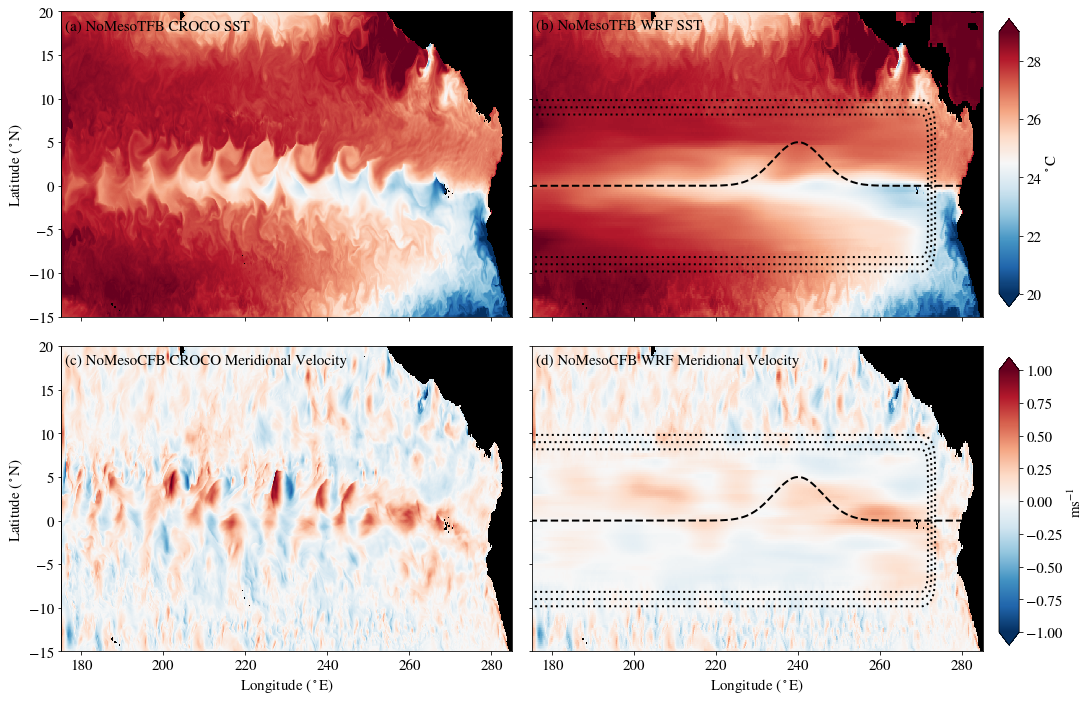

In [22]:
#Calculations:
time = '2016-11-01'
tlims = [20.,29.]

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(14,10),facecolor='w')

# SST:
#(data['CROCO-WRF Control-E1']['wrf_day'].SST-273.15).sel(time=time).plot(ax=axes[0][0],cmap='RdBu_r',vmin=tlims[0],vmax=tlims[1])
data['CROCO-WRF NoTFB-E1']['day'].temp_surf.sel(time=time).plot(ax=axes[0][0],cmap='RdBu_r',vmin=tlims[0],vmax=tlims[1],add_colorbar=False)
wrfSST = data['CROCO-WRF NoTFB-E1']['wrf_day'].SST.sel(time=time)-273.15
wrfSST = wrfSST.where(wrfSST > 10.)
im1 = wrfSST.plot(ax=axes[0][1],cmap='RdBu_r',vmin=tlims[0],vmax=tlims[1],add_colorbar=False)

# V:
data['CROCO-WRF NoMesoCFB-E1']['day'].v_surf.sel(time=time).plot(ax=axes[1][0],cmap='RdBu_r',vmin=-1.,vmax=1.,add_colorbar=False)
wrfV = data['CROCO-WRF NoMesoCFB-E1']['wrf_day'].VOCE.sel(time=time)
wrfV = wrfV.where(wrfV != 0.)
im2 = wrfV.plot(ax=axes[1][1],cmap='RdBu_r',vmin=-1.,vmax=1.,add_colorbar=False)



# Add Gaussian smoother and mask:
x = data['CROCO-WRF NoTFB-E1']['wrf_day'].SST.x
gausy = 5.*np.exp(-.5*(x-240.)**2./(24.*1./4.)**2.)
c = xr.open_dataset('/g/data/e14/rmh561/croco/data/OASIS_FILES/PAC12_75_cpl/smooth_mask_tanh.nc')
c = c.assign_coords({"y":data['CROCO-WRF NoTFB-E1']['wrf_day'].SST.x.values,"x":data['CROCO-WRF NoTFB-E1']['wrf_day'].SST.y.values})

axes[0][1].plot(x,gausy,'--k')
axes[1][1].plot(x,gausy,'--k')
c.SMOOTHMASK.plot.contour(x='y',y='x',ax=axes[0][1],levels=np.arange(0.25,1.25,0.25),colors='k',linestyles='dotted')
c.SMOOTHMASK.plot.contour(x='y',y='x',ax=axes[1][1],levels=np.arange(0.25,1.25,0.25),colors='k',linestyles='dotted')

for axs in axes.flatten():
    axs.set_facecolor('k')
    axs.set_xlabel('Longitude ($^\circ$E)')
    axs.set_ylabel('Latitude ($^\circ$N)')
    axs.set_title('')
    axs.set_xlim([175.,285.])
    axs.set_ylim([-15.,20.])
axes[0][0].set_xlabel('')
axes[0][0].set_xticklabels('')
axes[0][1].set_xlabel('')
axes[0][1].set_xticklabels('')
axes[0][1].set_ylabel('')
axes[0][1].set_yticklabels('')
axes[1][1].set_ylabel('')
axes[1][1].set_yticklabels('')

axes[0][0].text(176.,18,'(a) NoMesoTFB CROCO SST')
axes[0][1].text(176.,18,'(b) NoMesoTFB WRF SST')
axes[1][0].text(176.,18,'(c) NoMesoCFB CROCO Meridional Velocity')
axes[1][1].text(176.,18,'(d) NoMesoCFB WRF Meridional Velocity')

# axes[0][0].set_position([0.01,0.53,0.4,0.4])
# axes[0][1].set_position([0.01,0.01,0.4,0.4])
# axes[1][0].set_position([0.53,0.55,0.4,0.4])
# axes[1][1].set_position([0.53,0.01,0.4,0.4])
# for axs in axes.reshape(-1):
#     axs.set_aspect(1.2)
cb1_ax = fig.add_axes([1,.56,.02,.4])
fig.colorbar(im1,orientation='vertical',cax=cb1_ax,label='$^\circ$C',extend='both')
cb2_ax = fig.add_axes([1,0.09,.02,.4])
fig.colorbar(im2,orientation='vertical',cax=cb2_ax,label='ms$^{-1}$',extend='both')

plt.tight_layout()
plt.savefig('Production_Figures/SST_Example_2016-11.png',dpi=100)

# Surface flux snapshot figure

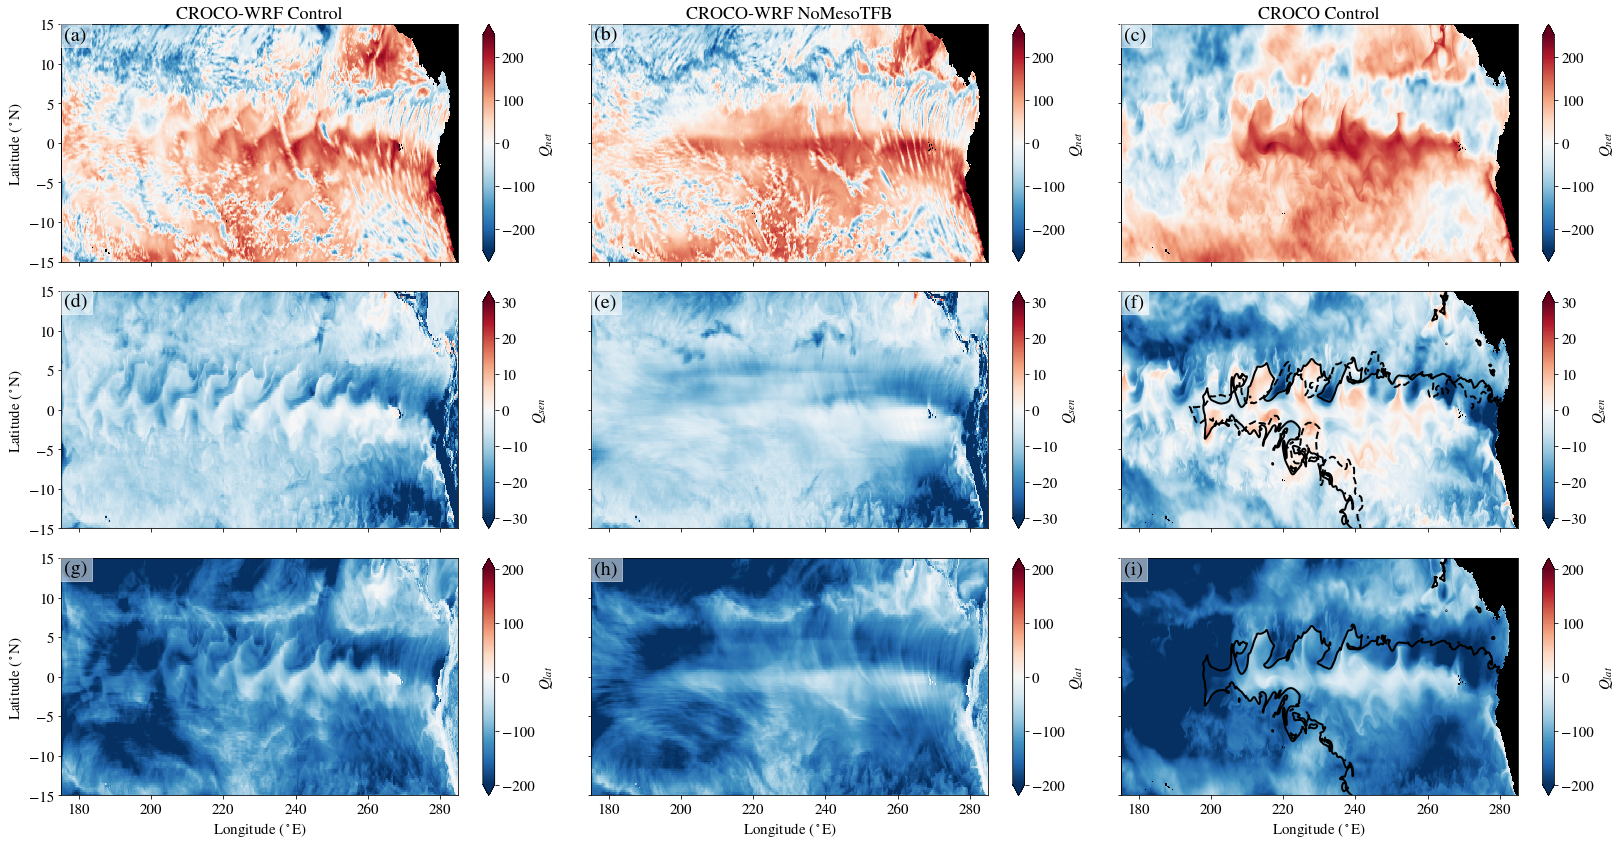

In [17]:
# surface heat fluxes:
times = ['2016-11-01','2016-11-01']
#times = ['2016-11-01','2016-11-12']

fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(23,12),facecolor='w')

# CROCO-only SST snapshots for sensible heat flux:
SST = data['CROCO Control']['day'].temp_surf.sel(time=slice(times[0],times[1])).mean('time')
OBS_SST = OISST.sst.sel(time=slice(times[0],times[1])).mean('time')

# SST:
# data['CROCO-WRF Control-E1']['day'].temp_surf.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[0][0],cmap='RdBu_r',vmin=18.,vmax=30.)
# axes[0][0].set_title('CROCO-WRF Control CROCO SST ($^\circ$C) ' + times[0] + ' ' + times[1])
# data['CROCO-WRF NoTFB-E1']['day'].temp_surf.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[0][1],cmap='RdBu_r',vmin=18.,vmax=30.)
# axes[0][1].set_title('CROCO-WRF NoTFB CROCO SST ($^\circ$C) ' + times[0] + ' ' + times[1])
# data['CROCO Control']['day'].temp_surf.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[0][2],cmap='RdBu_r',vmin=18.,vmax=30.)
# axes[0][2].set_title('CROCO Control CROCO SST ($^\circ$C) ' + times[0] + ' ' + times[1])

i = 0
# Total heat flux:
data['CROCO-WRF Control-E1']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i][0],cmap='RdBu_r',vmin=-250.,vmax=250.,cbar_kwargs={'label':'$Q_{net}$'},extend='both')
axes[i][0].set_title('CROCO-WRF Control CROCO $Q_{net}$ ' + times[0] + ' ' + times[1])
data['CROCO-WRF NoTFB-E1']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i][1],cmap='RdBu_r',vmin=-250.,vmax=250.,cbar_kwargs={'label':'$Q_{net}$'},extend='both')
axes[i][1].set_title('CROCO-WRF NoTFB CROCO $Q_{net}$ ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i][2],cmap='RdBu_r',vmin=-250.,vmax=250.,cbar_kwargs={'label':'$Q_{net}$'},extend='both')
axes[i][2].set_title('CROCO Control CROCO $Q_{net}$ ' + times[0] + ' ' + times[1])

# SST contours:
#data['CROCO-WRF Control-E1']['day'].temp_surf.sel(time=slice(times[0],times[1])).mean('time').plot.contour(ax=axes[0][0],levels=np.arange(0.,32.,2.),colors='k',add_colorbar=False)
#data['CROCO-WRF NoTFB-E1']['day'].temp_surf.sel(time=slice(times[0],times[1])).mean('time').plot.contour(ax=axes[0][1],levels=np.arange(0.,32.,2.),colors='k',add_colorbar=False)
#data['CROCO Control']['day'].temp_surf.sel(time=slice(times[0],times[1])).mean('time').plot.contour(ax=axes[0][2],levels=np.arange(0.,32.,2.),colors='k',add_colorbar=False)

# Sensible heat flux:
SHFLX = -data['CROCO-WRF Control-E1']['wrf_day'].HFX
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i+1][0],cmap='RdBu_r',vmin=-30.,vmax=30.,cbar_kwargs={'label':'$Q_{sen}$'},extend='both')
axes[i+1][0].set_title('CROCO-WRF Control WRF Sensible HF ' + times[0] + ' ' + times[1])
SHFLX = -data['CROCO-WRF NoTFB-E1']['wrf_day'].HFX
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i+1][1],cmap='RdBu_r',vmin=-30.,vmax=30.,cbar_kwargs={'label':'$Q_{sen}$'},extend='both')
axes[i+1][1].set_title('CROCO-WRF NoTFB WRF Sensible HF ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].shflx_sen.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i+1][2],cmap='RdBu_r',vmin=-30.,vmax=30.,cbar_kwargs={'label':'$Q_{sen}$'},extend='both')
axes[i+1][2].set_title('CROCO Control CROCO Sensible HF ' + times[0] + ' ' + times[1])

SST.plot.contour(ax=axes[i+1][2],levels=[26.],colors='k')
OBS_SST.plot.contour(ax=axes[i+1][2],levels=[26.],colors='k',linestyles='dashed')

# Latent heat flux:
SHFLX = -data['CROCO-WRF Control-E1']['wrf_day'].LH
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i+2][0],cmap='RdBu_r',vmin=-200.,vmax=200.,cbar_kwargs={'label':'$Q_{lat}$'},extend='both')
axes[i+2][0].set_title('CROCO-WRF Control WRF Latent HF ' + times[0] + ' ' + times[1])
SHFLX = -data['CROCO-WRF NoTFB-E1']['wrf_day'].LH
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i+2][1],cmap='RdBu_r',vmin=-200.,vmax=200.,cbar_kwargs={'label':'$Q_{lat}$'},extend='both')
axes[i+2][1].set_title('CROCO-WRF NoTFB WRF Latent HF ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].shflx_lat.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i+2][2],cmap='RdBu_r',vmin=-200.,vmax=200.,cbar_kwargs={'label':'$Q_{lat}$'},extend='both')
axes[i+2][2].set_title('CROCO Control CROCO Latent HF ' + times[0] + ' ' + times[1])
SST.plot.contour(ax=axes[i+2][2],levels=[26.],colors='k')

# # Shortwave heat flux:
# data['CROCO-WRF Control-E1']['day'].swrad.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i+3][0],cmap='RdBu_r',vmin=-350.,vmax=350.,cbar_kwargs={'label':'$Q_{sw}$'},extend='both')
# axes[i+3][0].set_title('CROCO-WRF Control CROCO SW Radiation ' + times[0] + ' ' + times[1])
# data['CROCO-WRF NoTFB-E1']['day'].swrad.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i+3][1],cmap='RdBu_r',vmin=-350.,vmax=350.,cbar_kwargs={'label':'$Q_{sw}$'},extend='both')
# axes[i+3][1].set_title('CROCO-WRF NoTFB CROCO SW Radiation ' + times[0] + ' ' + times[1])
# data['CROCO Control']['day'].radsw.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i+3][2],cmap='RdBu_r',vmin=-350.,vmax=350.,cbar_kwargs={'label':'$Q_{sw}$'},extend='both')
# axes[i+3][2].set_title('CROCO Control CROCO SW Radiation ' + times[0] + ' ' + times[1])

# # longwave heat flux:
# SHFLX = data['CROCO-WRF Control-E1']['wrf_day'].GLW-5.67e-8*(data['CROCO-WRF Control-E1']['wrf_day'].SST)**4
# SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i+4][0],cmap='RdBu_r',vmin=-100.,vmax=100.,cbar_kwargs={'label':'$Q_{lw}$'},extend='both')
# axes[i+4][0].set_title('CROCO-WRF Control WRF Longwave HF ' + times[0] + ' ' + times[1])
# SHFLX = data['CROCO-WRF NoTFB-E1']['wrf_day'].GLW-5.67e-8*(data['CROCO-WRF NoTFB-E1']['wrf_day'].SST)**4
# SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i+4][1],cmap='RdBu_r',vmin=-100.,vmax=100.,cbar_kwargs={'label':'$Q_{lw}$'},extend='both')
# axes[i+4][1].set_title('CROCO-WRF NoTFB WRF Longwave HF ' + times[0] + ' ' + times[1])
# data['CROCO Control']['day'].shflx_rlw.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[i+4][2],cmap='RdBu_r',vmin=-100.,vmax=100.,cbar_kwargs={'label':'$Q_{lw}$'},extend='both')
# axes[i+4][2].set_title('CROCO Control CROCO Longwave HF ' + times[0] + ' ' + times[1])

for i, ax in enumerate(axes.reshape(-1)):
    ax.set_ylim([-15.,15.])
    ax.set_xlim([175.,285.])
    ax.set_title('')
    ax.set_facecolor('k')
    t = ax.text(176.,13.1,letlab[i],fontsize=20)
    t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w'))
for ax in axes[:-1].reshape(-1):
    ax.set_xlabel('')
    ax.set_xticklabels('')
for ax in axes[-1]:
    ax.set_xlabel('Longitude ($^\circ$E)')
for ax in axes:
    for axs in ax[1:]:
        axs.set_ylabel('')
        axs.set_yticklabels('')
    ax[0].set_ylabel('Latitude ($^\circ$N)')
    
axes[0][0].set_title('CROCO-WRF Control')
axes[0][1].set_title('CROCO-WRF NoMesoTFB')
axes[0][2].set_title('CROCO Control')

plt.tight_layout()
plt.savefig('Surface_Fluxes_Example_2016-11-01.png',dpi=100)

# Surface mean state and variance differences (longitude-latitude), data loading:

In [26]:
# # Mean state variables:
# SST = {};SSH = {};SSS = {};SWFLX = {};
# TAUU = {};TAUV = {};SHFLX = {};U = {};V = {};

# # WRF variables:
# RAIN = {};WSPD = {}; WRFTAUM = {}; WRFTAUX = {}; WRFTAUY = {};
# Wdivv = {}; Wcurv = {}; Sdivv = {}; Scurv = {};
# WXv = {}; WYv = {};SXv = {}; SYv = {};
# WRFSSTv = {};

# # Variance quantities:
# SSTv = {}; SSHv = {};EKE = {};MKE = {};EWW = {};MWW = {};VSST = {}
# Qv = {}; Ge = {}; Gm = {};GeWRF={};GeWRFof={};GeWRFofsmt={};GeWRFofsmtew={};

# Quantities for APE generation (following Bishop et al. 2020):
rho0 = 1025.
Cp = 3985. # See scalars.h
Thetar = 13.5
Nr = 5.2e-3
alpha = 0.00031181 # time mean over domain at surface from control.
g = 9.81
CC = alpha**2.*g**2./Cp/Nr/Nr

# Units: degC^-2 m2 s-4 J-1 kg degC s2 = degC-1 m2 J-1 s-2 kg
# Q*SST = W m-2 degC
# total = J s-1 J-1 s-2 kg = kg s-3 = (kg m2 s-2) m-2 s-1 = J m-2 s-1 = W m-2

# Restrict seasonally:
def is_season(month):
    return (month >= 1) & (month <= 12) # Full year
#    return (month <= 2) | (month >= 12)  # DJF
#    return (month >= 7)                  # TIW season
def season_res(ds):
    ds = ds.sel(time=is_season(ds['time.month']))
    if len(ds.time) != 48:
        print('%03d' % (len(ds.time)) + ' != 48 for ' + ds.name)
    return(ds)

keys = expdict.keys()
for key in keys:
    print(key)
#     SST[key] = season_res(data[key]['mon'].temp.isel(s_rho=-1)).mean('time').load()
#     # SSH[key] = (season_res(data[key]['mon'].zeta).mean('time') - season_res(data[key]['mon'].zeta).mean('time').mean('x_rho').mean('y_rho')).load()
#     # SSS[key] = season_res(data[key]['mon'].salt.isel(s_rho=-1)).mean('time').load()
#     # SWFLX[key] = season_res(data[key]['mon'].swflx).mean('time').load()
#     # SHFLX[key] = season_res(data[key]['mon'].shflx).mean('time').load()
#     TAUU[key] = season_res(data[key]['mon'].sustr).mean('time').load()
#     TAUV[key] = season_res(data[key]['mon'].svstr).mean('time').load()
#     U[key] = season_res(data[key]['mon'].u.isel(s_rho=-1)).mean('time').load()
#     # V[key] = season_res(data[key]['mon'].v.isel(s_rho=-1)).mean('time').load()

#     # RAIN[key] = season_res(data[key]['wrf_day'].RAIN).mean('time').load()*86400./30. # units: mm/day
#     WSPD[key] = season_res(data[key]['wrf_day'].WSPD).mean('time').load()
#     # WRFTAUM[key] = season_res(data[key]['wrf_day'].TAUM).mean('time').load()
#     # WRFTAUX[key] = season_res(data[key]['wrf_day'].TAUX).mean('time').load()
#     # WRFTAUY[key] = season_res(data[key]['wrf_day'].TAUY).mean('time').load()
    Wdivv[key] = season_res(data[key]['wrf_mon_hp'].Wdiv_hp_var).mean('time').load()*1e10
    Wcurv[key] = season_res(data[key]['wrf_mon_hp'].Wcur_hp_var).mean('time').load()*1e10
#     Sdivv[key] = season_res(data[key]['wrf_mon_hp'].Sdiv_hp_var).mean('time').load()
#     Scurv[key] = season_res(data[key]['wrf_mon_hp'].Scur_hp_var).mean('time').load()
#     # WXv[key] = season_res(data[key]['wrf_mon_hp'].WX_hp_var).mean('time').load()
#     # WYv[key] = season_res(data[key]['wrf_mon_hp'].WY_hp_var).mean('time').load()
#     # SXv[key] = season_res(data[key]['wrf_mon_hp'].SX_hp_var).mean('time').load()
#     # SYv[key] = season_res(data[key]['wrf_mon_hp'].SY_hp_var).mean('time').load()
#     # WRFSSTv[key] = season_res(data[key]['wrf_mon_hp'].SST_hp_var).mean('time').load()
    
#    SSTv[key] = season_res(data[key]['mon_hp'].SST_hp_var).mean('time').load()
#     #SSHv[key] = season_res(data[key]['mon_hp'].SSH_hp_var).mean('time').load()
    # Uv = season_res(data[key]['mon_hp'].U_hp_var).mean('time').load()
    # Vv = season_res(data[key]['mon_hp'].V_hp_var).mean('time').load()
    # EKE[key] = grid.interp(Uv,'x',boundary='fill').rename({'y_u':'y_rho'})+grid.interp(Vv,'y',boundary='fill').rename({'x_v':'x_rho'})
    # Uv = season_res(data[key]['mon_hp'].U_lp_var).mean('time').load()
    # Vv = season_res(data[key]['mon_hp'].V_lp_var).mean('time').load()
    # MKE[key] = grid.interp(Uv,'x',boundary='fill').rename({'y_u':'y_rho'})+grid.interp(Vv,'y',boundary='fill').rename({'x_v':'x_rho'})
    # EWWu = season_res(data[key]['mon_hp'].EWWU).mean('time').load()
    # EWWv = season_res(data[key]['mon_hp'].EWWV).mean('time').load()
    # MWWu = season_res(data[key]['mon_hp'].MWWU).mean('time').load()
    # MWWv = season_res(data[key]['mon_hp'].MWWV).mean('time').load()
    # EWW[key] = (grid.interp(EWWu,'x',boundary='fill').rename({'y_u':'y_rho'})+grid.interp(EWWv,'y',boundary='fill').rename({'x_v':'x_rho'}))*1e3 # mNm-1s-1
    # MWW[key] = grid.interp(MWWu,'x',boundary='fill').rename({'y_u':'y_rho'})+grid.interp(MWWv,'y',boundary='fill').rename({'x_v':'x_rho'})
    # VSST[key] = season_res(data[key]['mon_hp'].VSST_hp).mean('time').load()*1.e2 # cm degC s-1
    
# # of -> calculated using offline fluxes
# # ofsmt -> calculated using low-pass smoothed skin temperature/SST
# # ofabw -> calculated using absolute rather than relative wind
# # ofsmtew -> calculated using low-pass smoothed skin temp, Tair and Qair.    # Qv[key] = season_res(data[key]['mon_hp'].Q_hp_var).mean('time').load()
#     # Ge[key] = CC*season_res(data[key]['mon_hp'].QSST_hp).mean('time').load()*1.e3  # mWm-2
#     # GeWRF[key] = -CC*season_res(data[key]['wrf_mon_hp'].QSST_hp).mean('time').load()*1.e3  # mWm-2
#     GeWRFof[key] = -CC*season_res(data[key]['wrf_mon_hp'].QofSST_hp).mean('time').load()*1.e3  # mWm-2
#     GeWRFofsmt[key] = -CC*season_res(data[key]['wrf_mon_hp'].QofsmtSST_hp).mean('time').load()*1.e3  # mWm-2
#   GeWRFofabw[key] = -CC*season_res(data[key]['wrf_mon_hp'].QofabwSST_hp).mean('time').load()*1.e3
    #if 'Control' in key:
#    GeWRFofsmtew[key] = -CC*season_res(data[key]['wrf_mon_hp'].QofsmtewSST_hp).mean('time').load()*1.e3  # mWm-2
    #else:
    #    GeWRFofsmtew[key] = -0*CC*season_res(data['CROCO-WRF Control-E1']['wrf_mon_hp'].QofsmtewSST_hp).mean('time').load()*1.e3  # mWm-2
    # Gm[key] = CC*season_res(data[key]['mon_hp'].QSST_lp).mean('time').load()
    
# Note: If this is bugging out then maybe try 3-22.07 kernal?


CROCO-WRF Control-E1
CROCO-WRF Control-E2
CROCO-WRF Control-E3
CROCO-WRF Control-E4
CROCO-WRF Control-E5
CROCO-WRF NoTFB-E1
CROCO-WRF NoTFB-E2
CROCO-WRF NoTFB-E3
CROCO-WRF NoTFB-E4
CROCO-WRF NoTFB-E5
CROCO-WRF NoMesoCFB-E1
CROCO-WRF NoMesoCFB-E2
CROCO-WRF NoMesoCFB-E3
CROCO-WRF NoMesoCFB-E4
CROCO-WRF NoMesoCFB-E5
CROCO-WRF NoCFB-E1
CROCO-WRF NoCFB-E2
CROCO-WRF NoCFB-E3
CROCO-WRF NoCFB-E4
CROCO-WRF NoCFB-E5


In [27]:
# Calculate ensembles:
lst = [SST,U,TAUU,WSPD,SSTv,EKE,EWW,MKE,MWW,VSST,Wcurv,Wdivv]#,GeWRFof,GeWRFofsmt,GeWRFofsmtew] # NoTFB
#runs = ['Control','NoTFB']
#lst = [SST,U,SSTv,EKE,MKE,EWW,MWW,VSST] #[SST,U,TAUU,WSPD,SSTv,Wdivv,Wcurv,EKE,EWW,MKE,MWW]#,GeWRFof,GeWRFofsmt] # NoMesoCFB/NoCFB
runs = ['Control','NoMesoCFB','NoCFB','NoTFB']

def ens_avg(objs): 
    return(sum(objs)/len(objs))

for obj in lst:
    for run in runs:
        obj['CROCO-WRF ' + run] = ens_avg([obj['CROCO-WRF ' + run + '-E%01d' % (x+1)] for x in range(eL)]).load()
cont = 'CROCO-WRF Control'

In [28]:
# Calculate significance levels for perturbations:
typ = 'Welch'
### Option 1: Z score on Control ensemble:
if (typ == 'ConZ'):
    zScore = 2.58 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)
    for obj in lst:

        # Calculate standard deviation:
        std = np.zeros_like(obj['CROCO-WRF Control-E1'])
        for e in range(eL):
            std += (obj['CROCO-WRF Control-E%01d' % (e+1)]-obj['CROCO-WRF Control'])**2.
        std = np.sqrt(std/eL)

        for key in keys:
            obj[key + '-s'] = xr.zeros_like(obj[key])
            obj[key + '-s'].values = np.where(abs(obj[key].values-obj['CROCO-WRF Control'])>(zScore*std),1.,0.)

### Option 2: Instead use outside range of ensemble members:
elif (typ == 'ConR'):    # 
    yL, xL = np.shape(obj['CROCO-WRF Control-E1'].values)
    tmp = np.zeros((yL,xL,eL))
    for e in range(eL):
        tmp[:,:,e] = obj[pert].values - obj['CROCO-WRF Control-E%01d' % (e+1)].values

    obj[key + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
    obj[key + '-s'].values = np.logical_or(np.all(tmp>0.,axis=2),np.all(tmp<0.,axis=2))
    
### Option 3: Welch's t-test (https://en.wikipedia.org/wiki/Welch%27s_t-test) on two distributions:
elif (typ == 'Welch'):
    critp = 0.05  # critical p-value
    for obj in lst:

        # Calculate standard deviations:
        std = {}
        for run in runs:
            std[run] = np.zeros_like(obj['CROCO-WRF Control-E1'])
            for e in range(eL):
                std[run] += (obj['CROCO-WRF ' + run + '-E%01d' % (e+1)]-obj['CROCO-WRF ' + run])**2.
            std[run] = np.sqrt(std[run]/(eL-1)) # Corrected sample standard deviation https://en.wikipedia.org/wiki/Standard_deviation#Corrected_sample_standard_deviation

        # Calculate t and degrees-of-freedom:
        t = {}
        nu = {}
        for run in runs:
            s1 = std[run]/np.sqrt(eL)
            s2 = std['Control']/np.sqrt(eL)
            sd = np.sqrt(s1**2.+s2**2.)
            t[run] = (obj['CROCO-WRF ' + run] - obj['CROCO-WRF Control'])/sd
            nu[run] = (eL-1)*sd**4./(s1**4.+s2**4.)
        
        # Calculate p-value
        p = {}
        for run in runs:
            p[run] = stats.t.sf(np.abs(t[run]), nu[run]-1)*2
            obj['CROCO-WRF ' + run + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
            obj['CROCO-WRF ' + run + '-s'].values = np.where(p[run]<critp,1.,0.)

In [29]:
LONS = 210., 260.

#keys = list(expdict.keys()) + ['CROCO-WRF Control']
keys = list(expdict.keys()) + ['CROCO-WRF Control','CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']

SSTll = {};SWFLXll={};SSHll = {};Ull={};Vll={};SSSll={};TAUUll={};TAUVll={};SHFLXll={};
RAINll={};WSPDll={}; WRFTAUMll = {}; WRFTAUXll = {}; WRFTAUYll = {};
SSTvll = {};SSHvll = {};EKEll={};MKEll={};EWWll={};MWWll={};VSSTll={}
Wdivvll = {}; Wcurvll = {}; Sdivvll = {}; Scurvll = {};WXvll = {}; WYvll = {};SXvll = {}; SYvll = {};WRFSSTvll = {};
Gell = {};Gmll = {};Qvll = {};GeWRFll = {};GeWRFofll = {};GeWRFofsmtll = {};GeWRFofsmtewll = {};
for key in keys:
    print(key)
    SSTll[key] = SST[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # SSHll[key] = SSH[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # SWFLXll[key] = SWFLX[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    Ull[key] = U[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    # Vll[key] = V[key].sel(x_v=slice(LONS[0],LONS[1])).mean('x_v').load()
    # SSSll[key] = SSS[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    TAUUll[key] = TAUU[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    # TAUVll[key] = TAUV[key].sel(x_v=slice(LONS[0],LONS[1])).mean('x_v').load()
    # SHFLXll[key] = SHFLX[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    
    # RAINll[key] = RAIN[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    WSPDll[key] = WSPD[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # WRFTAUMll[key] = WRFTAUM[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # WRFTAUXll[key] = WRFTAUX[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # WRFTAUYll[key] = WRFTAUY[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    Wdivvll[key] = Wdivv[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    Wcurvll[key] = Wcurv[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    # Sdivvll[key] = Sdivv[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    # Scurvll[key] = Scurv[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    # WXvll[key] = WXv[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # WYvll[key] = WYv[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # SXvll[key] = SXv[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # SYvll[key] = SYv[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    
    SSTvll[key] = SSTv[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # SSHvll[key] = SSHv[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    EKEll[key] = EKE[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    MKEll[key] = MKE[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    EWWll[key] = EWW[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    MWWll[key] = MWW[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    VSSTll[key] = VSST[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    
    # Qvll[key] = Qv[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # Gell[key] = Ge[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # GeWRFll[key] = GeWRF[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # GeWRFofll[key] = GeWRFof[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # GeWRFofsmtll[key] = GeWRFofsmt[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # GeWRFofsmtewll[key] = GeWRFofsmtew[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # Gmll[key] = Gm[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()

CROCO-WRF Control-E1
CROCO-WRF Control-E2
CROCO-WRF Control-E3
CROCO-WRF Control-E4
CROCO-WRF Control-E5
CROCO-WRF NoTFB-E1
CROCO-WRF NoTFB-E2
CROCO-WRF NoTFB-E3
CROCO-WRF NoTFB-E4
CROCO-WRF NoTFB-E5
CROCO-WRF NoMesoCFB-E1
CROCO-WRF NoMesoCFB-E2
CROCO-WRF NoMesoCFB-E3
CROCO-WRF NoMesoCFB-E4
CROCO-WRF NoMesoCFB-E5
CROCO-WRF NoCFB-E1
CROCO-WRF NoCFB-E2
CROCO-WRF NoCFB-E3
CROCO-WRF NoCFB-E4
CROCO-WRF NoCFB-E5
CROCO-WRF Control
CROCO-WRF NoTFB
CROCO-WRF NoMesoCFB
CROCO-WRF NoCFB


In [30]:
# Calculate standard error ranges for ensembles:
zScore = 1.96 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)

# NoTFB:
lst = [SSTll,Ull,WSPDll,Wdivvll,Wcurvll,SSTvll,EKEll,EWWll,VSSTll,GeWRFll,GeWRFofll,GeWRFofsmtll,GeWRFofsmtewll]
runs = ['Control','NoTFB']

# NoCFB:
lst = [SSTll,Ull,TAUUll,WSPDll,SSTvll,EKEll,EWWll,MKEll,MWWll,VSSTll,Wdivvll,Wcurvll]#[SSTll,Ull,TAUUll,WSPDll,SSTvll,Wdivvll,Wcurvll,EKEll,EWWll,MKEll,MWWll]#,GeWRFof,GeWRFofsmt] # NoMesoCFB/NoCFB
runs = ['Control','NoMesoCFB','NoCFB']

# All:
#lst = [SSTll,Ull,TAUUll,TAUVll,WSPDll,SSTvll,Wdivvll,Wcurvll,Sdivvll,Scurvll,EKEll,EWWll,MKEll,MWWll,VSSTll,GeWRFofll,GeWRFofsmtll,GeWRFofsmtewll] # NoTFB

#runs = ['Control','NoMesoCFB','NoCFB','NoTFB']

for obj in lst:
    
    for run in runs:
        # Calculate standard error:
        obj['CROCO-WRF ' + run + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
        for e in range(eL):
            obj['CROCO-WRF ' + run + '-s'] += (obj['CROCO-WRF ' + run + '-E%01d' % (e+1)]-obj['CROCO-WRF ' + run])**2.
        obj['CROCO-WRF ' + run + '-s'] = np.sqrt(obj['CROCO-WRF ' + run + '-s']/eL)/np.sqrt(eL)

# Production NoTFB x-y changes plot

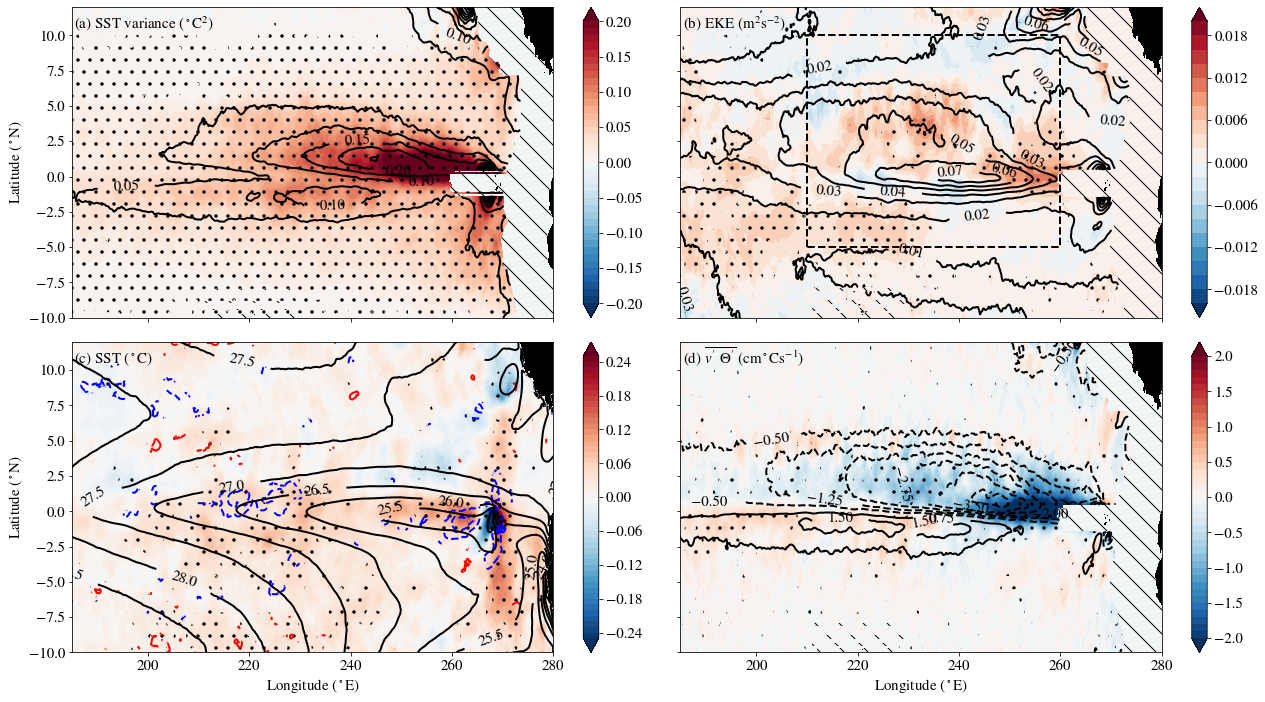

In [19]:
key = 'CROCO-WRF NoTFB'

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(18,10),facecolor='w')
axs = axes.flatten()

# Get land mask working:
mask = SST[cont].where(~np.isnan(SST[cont]),0,1)
mask = mask/mask-1

#SSTv:
#SSTvdiff = SSTv[key]-SSTv[cont]
#SSTvdiff = SSTvdiff.fillna(0.).where(mask==1)
mask.plot.contourf(ax=axs[0],levels=np.arange(-0.2,0.21,0.01),cmap='RdBu_r',add_colorbar=False)
xr.where(mask==0.,1.,0.).plot.contourf(ax=axs[0],levels=[-0.5, 0.5, 1.25],hatches=[None,"\\"],colors='none',add_colorbar=False)
(SSTv[cont]-SSTv[key]).plot.contourf(ax=axs[0],levels=np.arange(-0.2,0.21,0.01),cmap='RdBu_r',extend='both',cbar_kwargs={'label':''})
SSTv[key+'-s'].plot.contourf(ax=axs[0],levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
CS = SSTv[cont].plot.contour(ax=axs[0],levels=np.arange(0.05,0.6,0.05),colors='k',linewidth=.5)
mask.plot.contour(ax=axs[0],levels=[0.5, 0.5],colors='w',linewidth=.5)
axs[0].clabel(CS, CS.levels, inline=True, fontsize=15)


#EKE:
mask.plot.contourf(ax=axs[1],levels=np.arange(-0.015,0.016,0.001),cmap='RdBu_r',add_colorbar=False)
xr.where(mask==0.,1.,0.).plot.contourf(ax=axs[1],levels=[-0.5, 0.5, 1.25],hatches=[None,"\\"],colors='none',add_colorbar=False)
(EKE[cont]-EKE[key]).plot.contourf(ax=axs[1],levels=np.arange(-0.02,0.022,0.002),cmap='RdBu_r',extend='both',cbar_kwargs={'label':''})
EKE[key+'-s'].plot.contourf(ax=axs[1],levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
CS = EKE[cont].plot.contour(ax=axs[1],levels=np.arange(0.01,0.31,0.01),colors='k',linewidth=.5)
axs[1].clabel(CS, CS.levels, inline=True, fontsize=15)

#SST:
(SST[cont]-SST[key]).plot.contourf(ax=axs[2],levels=np.arange(-0.2,0.205,0.005),cmap='RdBu_r',extend='both',cbar_kwargs={'label':''})
SST[key+'-s'].plot.contourf(ax=axs[2],levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
Uch = (U[key]-U[cont])
Uch = Uch.where(U[key+'-s']==1.)
CS = Uch.plot.contour(ax=axs[2],levels=np.arange(0.01,0.51,0.01),colors='r',linestyle='-',linewidth=.5)
CS = Uch.plot.contour(ax=axs[2],levels=np.arange(-0.51,-0.0,0.01),colors='b',linestyle='-',linewidth=.5)
CS = SST[cont].plot.contour(ax=axs[2],levels=np.arange(0,34,.5),colors='k',linewidth=.5)
axs[2].clabel(CS, CS.levels, inline=True, fontsize=15)

# #Ge:
# (Ge[key]-Ge[cont]).plot.contourf(ax=axs[3],levels=np.arange(-0.0008,0.00085,0.00005),cmap='RdBu_r',extend='both',cbar_kwargs={'label':''})
# Ge[key+'-s'].plot.contourf(ax=axs[3],levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
# CS = Ge[cont].plot.contour(ax=axs[3],levels=np.arange(0.0002,0.0052,0.0002),colors='k',linestyle='-',linewidth=.5)
# axs[3].clabel(CS, CS.levels, inline=True, fontsize=15)
# CS = Ge[cont].plot.contour(ax=axs[3],levels=np.arange(-0.0052,0.,0.0002),colors='k',linestyle='dashed',linewidth=.5)
# axs[3].clabel(CS, CS.levels, inline=True, fontsize=15)

# Alternative VSST:
mask.plot.contourf(ax=axs[3],levels=np.arange(-2,2.1,0.1),cmap='RdBu_r',add_colorbar=False)
xr.where(mask==0.,1.,0.).plot.contourf(ax=axs[3],levels=[-0.5, 0.5, 1.25],hatches=[None,"\\"],colors='none',add_colorbar=False)
(VSST[cont]-VSST[key]).plot.contourf(ax=axs[3],levels=np.arange(-2,2.1,0.1),cmap='RdBu_r',extend='both',cbar_kwargs={'label':''})
VSST[key+'-s'].plot.contourf(ax=axs[3],levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
CS = VSST[cont].plot.contour(ax=axs[3],levels=np.arange(0.75,8.75,0.75),colors='k',linestyle='-',linewidth=.5)
axs[3].clabel(CS, CS.levels, inline=True, fontsize=15)
CS = VSST[cont].plot.contour(ax=axs[3],levels=np.arange(-8.75,0.,0.75),colors='k',linestyle='dashed',linewidth=.5)
axs[3].clabel(CS, CS.levels, inline=True, fontsize=15)

# axs[3].text(185.5,13.6,'(d) $G_e$ (Wm$^{-2}$)')
# axs[0].text(185.5,13.6,'(a) SST variance ($^\circ$C$^2$)')
# axs[1].text(185.5,13.6,'(b) EKE (m$^2$s$^{-2}$)')
# axs[2].text(185.5,13.6,'(c) SST ($^\circ$C)')
axs[3].text(185.5,10.5,'(d) $\overline{v\'\,\,\Theta\'}$ (cm$^\circ$Cs$^{-1}$)')
axs[0].text(185.5,10.5,'(a) SST variance ($^\circ$C$^2$)')
axs[1].text(185.5,10.5,'(b) EKE (m$^2$s$^{-2}$)')
axs[2].text(185.5,10.5,'(c) SST ($^\circ$C)')

for ax in axs:
    ax.set_facecolor('k')
    ax.set_xlim([185.,280.])
    ax.set_ylim([-10.,12.])
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
    ax.set_title('')
for ax in [axs[0],axs[1]]:
    ax.set_xlabel('')
    ax.set_xticklabels('')
for ax in [axs[1],axs[3]]:
    ax.set_ylabel('')
    ax.set_yticklabels('')
axs[1].plot([210.,210.,260.,260.,210.],[-5.,10.,10.,-5.,-5.],'--k')
plt.tight_layout()
axs[0].set_title('Control - NoMesoTFB')
axs[1].set_title('Control - NoMesoTFB')
plt.savefig('Production_Figures/NoTFB_xy_SSTvEKESSTVSST.png',dpi=100)

# Production NoTFB latitude sections changes plot

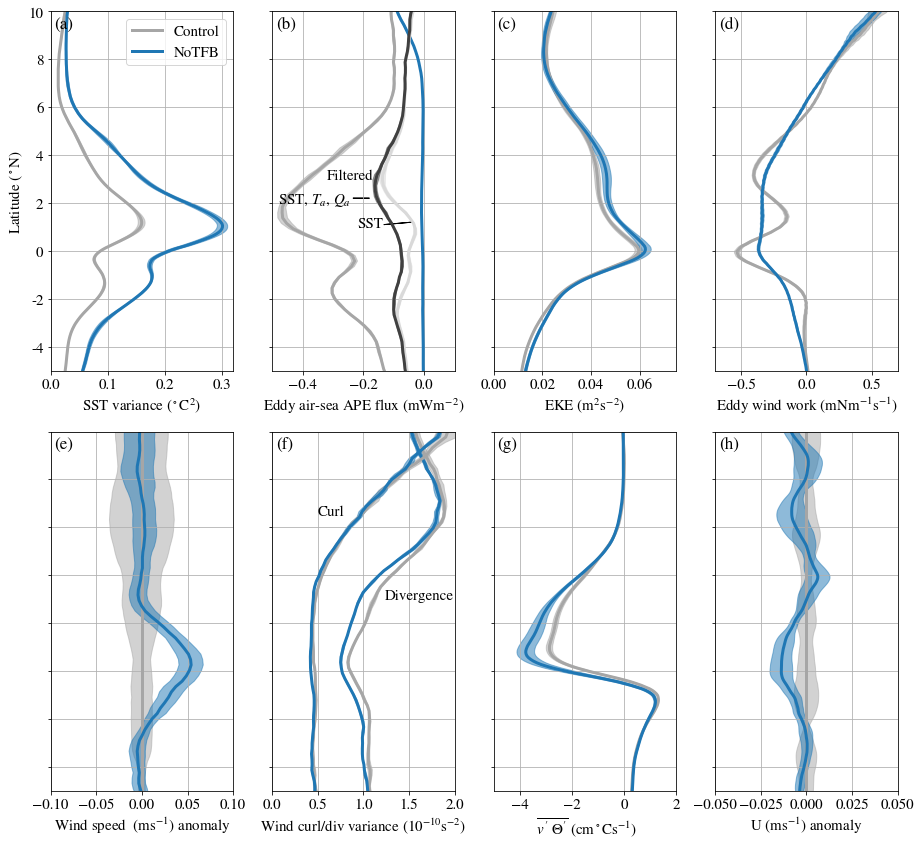

In [59]:
# Latitude line plots (all ensembles):
fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(13,12),facecolor='w')

axs = axes.flatten()

fix_xlims = True
cont = 'CROCO-WRF NoTFB'

runs = ['Control','NoTFB']
cols = ['0.65','C0','C1','C2']
labels = ['Control','NoMesoTFB']
varsd = [
    # NoTFB production:
        {'var':SSTvll,'label':'SST variance ($^\circ$C$^2$)','xlim':[0.,0.32],'yco':'y_rho','anom':False,'add_p':False},
        {'var':GeWRFofll,'label':'Eddy air-sea APE flux (mWm$^{-2}$)','xlim':[-.5,.1],'yco':'y','anom':False,'add_p':False},
        {'var':EKEll,'label':'EKE (m$^2$s$^{-2}$)','xlim':[0.,0.075],'yco':'y_rho','anom':False,'add_p':False},
        {'var':EWWll,'label':'Eddy wind work (mNm$^{-1}$s$^{-1}$)','xlim':[-7.e-1,7.e-1],'yco':'y_rho','anom':False,'add_p':False},
        {'var':WSPDll,'label':'Wind speed  (ms$^{-1}$)','xlim':[-0.1,0.1],'yco':'y','anom':True,'add_p':False},
        {'var':Wdivvll,'label':'Wind curl/div variance ($10^{-10}$s$^{-2}$)','xlim':[0.,20],'yco':'y_v','anom':False,'add_p':False},
        {'var':VSSTll,'label':' $\overline{v\'\,\,\Theta\'}$ (cm$^\circ$Cs$^{-1}$)','xlim':[-5,2],'yco':'y_rho','anom':False,'add_p':False},
        {'var':Ull,'label':'U (ms$^{-1}$)','xlim':[-0.05,0.05],'yco':'y_u','anom':True,'add_p':False},
#        {'var':Wcurvll,'label':'Wind Curl Variance [s-2]','xlim':[0.,0.2e-9],'yco':'y_v','anom':False,'add_p':False},
#         {'var':SSTll,'label':'SST  ($^\circ$C)','xlim':[-0.1,0.1],'yco':'y_rho','anom':True,'add_p':False},
#     # Variance absolutes:
#         {'var':SSHvll,'label':'SSH Variance [m2]','axlim':[-0.001,0.001],'mxlim':[0.,0.002],'yco':'y_rho','anom':False,'add_p':True},
#         {'var':MKEll,'label':'MKE [m2s-2]','axlim':[-0.02,0.08],'mxlim':[0.,0.4],'yco':'y_rho','anom':False,'add_p':True},
#         {'var':MWWll,'label':'Mean Wind Work [Nm-1s-1]','axlim':[-.4e-3,.5e-3],'mxlim':[0.,0.021],'yco':'y_rho','anom':False,'add_p':True},   
# # Other:
#         {'var':TAUUll,'label':'Zonal Wind Stress [Nm-2]','axlim':[-0.002,0.002],'mxlim':[-60.e-3,-30.e-3],'yco':'y_u','anom':False,'add_p':False},
#         {'var':TAUVll,'label':'Meridional Wind Stress [Nm-2]','axlim':[-2.5e-3,1.5e-3],'mxlim':[-20.e-3,25.e-3],'yco':'y_v','anom':False,'add_p':False},
#         {'var':SWFLXll,'label':'Surface net volume flux [mm/day]','axlim':[-0.75,0.75],'mxlim':[-10.,10.],'yco':'y_rho','anom':True,'add_p':False},
# #         {'var':SSSll,'label':'SSS [psu]','axlim':[-0.05,0.15],'mxlim':[34.25,35.5]},
# #        {'var':SHFLXll,'label':'Surface net heat flux [Wm-2]','axlim':[-4.,4.],'mxlim':[0.,120.],'yco':'y_rho','anom':False,'add_p':False},
    # # WRF Stresses:
    #    {'var':WRFTAUMll,'label':'Wind Stress Magnitude (Nm$^{-2}$)]','xlim':[0.035,0.08],'yco':'y','anom':False,'add_p':False},
    #     {'var':WRFTAUXll,'label':'Zonal Wind Stress [Nm-2]','axlim':[-0.002,0.002],'mxlim':[-60.e-3,-30.e-3],'yco':'y','anom':False,'add_p':False},
    #     {'var':WRFTAUYll,'label':'Meridional Wind Stress [Nm-2]','axlim':[-2.5e-3,1.5e-3],'mxlim':[-20.e-3,25.e-3],'yco':'y','anom':False,'add_p':False},
    #     {'var':WRFTAUMll,'label':'Wind Stress Magnitude [Nm-2]','axlim':[-0.002,0.002],'mxlim':[0.,0.08],'yco':'y','anom':True,'add_p':False},
    #     {'var':WRFTAUXll,'label':'Zonal Wind Stress [Nm-2]','axlim':[-0.002,0.002],'mxlim':[-60.e-3,-30.e-3],'yco':'y','anom':True,'add_p':False},
    #     {'var':WRFTAUYll,'label':'Meridional Wind Stress [Nm-2]','axlim':[-2.5e-3,1.5e-3],'mxlim':[-20.e-3,25.e-3],'yco':'y','anom':True,'add_p':False},
    #     {'var':WRFTAUMll,'label':'Wind Stress Magnitude [Nm-2]','axlim':[-0.002,0.002],'mxlim':[0.,0.08],'yco':'y','anom':True,'add_p':False},
    #     {'var':WRFTAUXll,'label':'Zonal Wind Stress [Nm-2]','axlim':[-0.002,0.002],'mxlim':[-60.e-3,-30.e-3],'yco':'y','anom':True,'add_p':False},
    #     {'var':WRFTAUYll,'label':'Meridional Wind Stress [Nm-2]','axlim':[-2.5e-3,1.5e-3],'mxlim':[-20.e-3,25.e-3],'yco':'y','anom':True,'add_p':False},
    # # High-pass wind/stress variances:
    #     {'var':WXvll,'label':'Zonal wind variance [m2s-2]','xlim':[0.,.75],'yco':'y','anom':False,'add_p':False},
    #     {'var':WYvll,'label':'Meridional wind variance [m2s-2]','xlim':[0.,.75],'yco':'y','anom':False,'add_p':False},
    #     {'var':SXvll,'label':'Zonal stress variance [N2m-4]','xlim':[0.,2.e-4],'yco':'y','anom':False,'add_p':False},
    #     {'var':SYvll,'label':'Meridional stress variance [N2m-4]','xlim':[0.,2.e-4],'yco':'y','anom':False,'add_p':False},
    #     {'var':WXvll,'label':'Zonal wind variance [m2s-2]','xlim':[-1.e-1,1.e-1],'yco':'y','anom':True,'add_p':False},
    #     {'var':WYvll,'label':'Meridional wind variance [m2s-2]','xlim':[-1.e-1,1.e-1],'yco':'y','anom':True,'add_p':False},
    #     {'var':SXvll,'label':'Zonal stress variance [N2m-4]','xlim':[-.4e-4,.4e-4],'yco':'y','anom':True,'add_p':False},
    #     {'var':SYvll,'label':'Meridional stress variance [N2m-4]','xlim':[-.4e-4,.4e-4],'yco':'y','anom':True,'add_p':False},
    #     {'var':Sdivvll,'label':'Stress Divergence Variance (s$^{-2}$)','xlim':[0.,0.05e-12],'yco':'y_v','anom':False,'add_p':False},
    #     {'var':Scurvll,'label':'Stress Curl Variance [s-2]','xlim':[0.,0.04e-12],'yco':'y_v','anom':False,'add_p':False},
    #     {'var':Wdivvll,'label':'Wind Divergence Variance [s-2]','xlim':[-2.e-11,2.e-11],'yco':'y_v','anom':True,'add_p':False},
    #     {'var':Wcurvll,'label':'Wind Curl Variance [s-2]','xlim':[-1.e-11,1.e-11],'yco':'y_v','anom':True,'add_p':False},
    #     {'var':Sdivvll,'label':'Stress Divergence Variance [s-2]','xlim':[-.5e-14,.5e-14],'yco':'y_v','anom':True,'add_p':False},
    #     {'var':Scurvll,'label':'Stress Curl Variance [s-2]','xlim':[-.5e-14,.5e-14],'yco':'y_v','anom':True,'add_p':False},
    # High-pass surface heat flux variance quantities:
#        {'var':WXvll,'label':'Zonal wind variance [m2s-2]','xlim':[0.,.75],'yco':'y','anom':False,'add_p':False},
#        {'var':WYvll,'label':'Meridional wind variance [m2s-2]','xlim':[0.,.75],'yco':'y','anom':False,'add_p':False},
#        {'var':SXvll,'label':'Zonal stress variance [N2m-4]','xlim':[0.,2.e-4],'yco':'y','anom':False,'add_p':False},
#        {'var':Gmll,'label':'Mean APE Production [Wm-2]','xlim':[0.,0.5],'yco':'y_rho','anom':False,'add_p':False},
        ]

for i,varss in enumerate(varsd):
    for j,run in enumerate(runs):
        for k in range(eL):
            ckey = 'CROCO-WRF ' + run
            key = ckey + '-E%01d' % (k+1)
            if varss['anom']:
                var = varss['var'][key]-varss['var'][cont]
                varc = varss['var'][ckey]-varss['var'][cont]
            else:
                var = varss['var'][key]
                varc = varss['var'][ckey]
#            var.plot(y=varss['yco'],ax=axs[i],color=cols[j],linewidth=0.5,alpha=0.75)
        varc.plot(y=varss['yco'],ax=axs[i],label=labels[j],color=cols[j],linewidth=3.)
        std = varss['var'][ckey + '-s']
        axs[i].fill_betweenx(std[varss['yco']],-zScore*std+varc,zScore*std+varc,color=cols[j],alpha=0.5)
    lab = varss['label']
    if varss['anom']: lab+= ' anomaly'        
    axs[i].set_xlabel(lab)
    if fix_xlims:
        axs[i].set_xlim(varss['xlim'])

# Add extras:
# Wcur:
varss = {'var':Wcurvll,'label':'Wind curl/div variance ($10^{-10}$s$^{-2}$)','xlim':[0.,2],'yco':'y_v','anom':False,'add_p':False}
i = 5
for j,run in enumerate(runs):
    for k in range(eL):
        ckey = 'CROCO-WRF ' + run
        key = ckey + '-E%01d' % (k+1)
        if varss['anom']:
            var = varss['var'][key]-varss['var'][cont]
            varc = varss['var'][ckey]-varss['var'][cont]
        else:
            var = varss['var'][key]
            varc = varss['var'][ckey]
    varc.plot(y=varss['yco'],ax=axs[i],label=labels[j],color=cols[j],linewidth=3.)
    std = varss['var'][ckey + '-s']
    axs[i].fill_betweenx(std[varss['yco']],-zScore*std+varc,zScore*std+varc,color=cols[j],alpha=0.5)
lab = varss['label']
if varss['anom']: lab+= ' anomaly'        
axs[i].set_xlabel(lab)
if fix_xlims:
    axs[i].set_xlim(varss['xlim'])
axs[i].text(1.23,3.,'Divergence')
axs[i].text(.5,6.5,'Curl')
# Ge:
varss = {'var':GeWRFofsmtll,'label':'Eddy air-sea APE flux (mWm$^{-2}$)','xlim':[-.5,.1],'yco':'y','anom':False,'add_p':False}
i = 1
j = 0
run = 'Control'
for k in range(eL):
    ckey = 'CROCO-WRF ' + run
    key = ckey + '-E%01d' % (k+1)
    if varss['anom']:
        var = varss['var'][key]-varss['var'][cont]
        varc = varss['var'][ckey]-varss['var'][cont]
    else:
        var = varss['var'][key]
        varc = varss['var'][ckey]
varc.plot(y=varss['yco'],ax=axs[i],label=labels[j],color='0.85',linewidth=3.)
std = varss['var'][ckey + '-s']
axs[i].fill_betweenx(std[varss['yco']],-zScore*std+varc,zScore*std+varc,color='0.85',alpha=0.5)
lab = varss['label']
if varss['anom']: lab+= ' anomaly'        
axs[i].set_xlabel(lab)
if fix_xlims:
    axs[i].set_xlim(varss['xlim'])
# Ge:
varss = {'var':GeWRFofsmtewll,'label':'Eddy air-sea APE flux (mWm$^{-2}$)','xlim':[-.5,.1],'yco':'y','anom':False,'add_p':False}
i = 1
j = 0
run = 'Control'
for k in range(eL):
    ckey = 'CROCO-WRF ' + run
    key = ckey + '-E%01d' % (k+1)
    if varss['anom']:
        var = varss['var'][key]-varss['var'][cont]
        varc = varss['var'][ckey]-varss['var'][cont]
    else:
        var = varss['var'][key]
        varc = varss['var'][ckey]
varc.plot(y=varss['yco'],ax=axs[i],label=labels[j],color='0.25',linewidth=3.)
std = varss['var'][ckey + '-s']
axs[i].fill_betweenx(std[varss['yco']],-zScore*std+varc,zScore*std+varc,color='0.25',alpha=0.5)
lab = varss['label']
if varss['anom']: lab+= ' anomaly'        
axs[i].set_xlabel(lab)
if fix_xlims:
    axs[i].set_xlim(varss['xlim'])
#axs[i].text(-0.199,0.7,'Filtered')
#axs[i].text(-0.14,-0.2,'SST')
axs[i].text(-0.32,3,'Filtered')
axs[i].text(-0.48,2,'SST, $T_a$, $Q_a$')
axs[i].text(-0.22,1,'SST')
axs[i].arrow(-0.18,2.2,-0.05,0.)
axs[i].arrow(-0.04,1.2,-0.09,-0.1)

for ax in axs:
    ax.grid()
    ax.set_ylabel('')
    ax.set_yticklabels({})
    ax.set_title('')
for i, ax in enumerate(axs):
    ax.set_yticks(np.arange(-10.,20.,2.))
    ax.set_ylim([-5.,10.])
    xlims = ax.get_xlim()
    ax.text(xlims[0]+(xlims[1]-xlims[0])*0.02,9.3,letlab[i],fontsize=17)
axs[0].set_ylabel('Latitude ($^\circ$N)')
axs[0].set_yticklabels(np.arange(-10,20,2))
axs[0].legend(loc='upper right')
axs[4].set_ylabel('Latitude ($^\circ$N)')
axs[4].set_yticklabels(np.arange(-10,20,2))
# for ax in [axes[i] for i in range(np.shape(axes)[0])]:
#     ax.set_ylabel('Latitude ($^\circ$N)')
#     ax.set_yticklabels(np.arange(-10.,20.,2.))
#axs[7].legend(loc='upper left')
#axs[12].legend(loc='upper right')

plt.tight_layout()
plt.savefig('Production_Figures/NoTFB_latprofile_210to260.png',dpi=100)

# Production NoCFB x-y changes plot

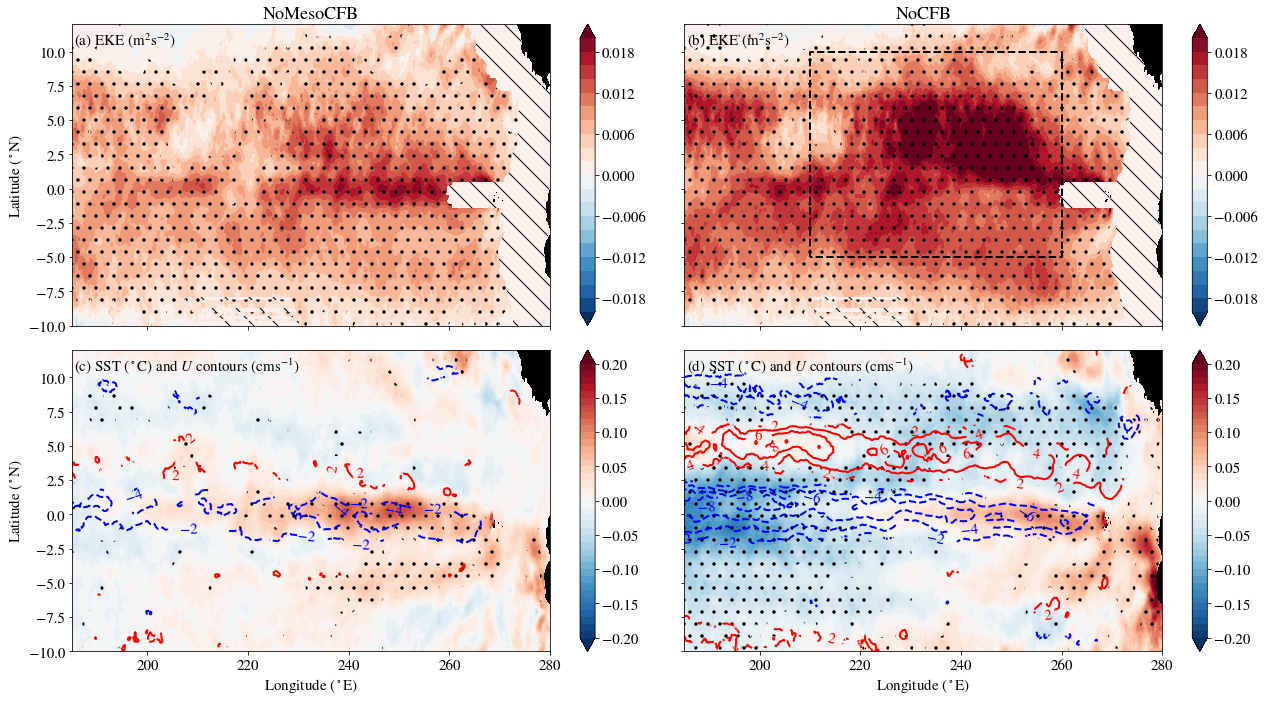

In [26]:
keys = ['CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(18,10),facecolor='w')
axs = axes.flatten()

# Get land mask working:
mask = SST[cont].where(~np.isnan(SST[cont]),0,1)
mask = mask/mask-1

for i, key in enumerate(keys):
    #EKE:
    mask.plot.contourf(ax=axs[0+i],levels=np.arange(-0.02,0.022,0.002),cmap='RdBu_r',add_colorbar=False)
    xr.where(mask==0.,1.,0.).plot.contourf(ax=axs[0+i],levels=[-0.5, 0.5, 1.25],hatches=[None,"\\"],colors='none',add_colorbar=False)
    (EKE[cont]-EKE[key]).plot.contourf(ax=axs[0+i],levels=np.arange(-0.02,0.022,0.002),cmap='RdBu_r',extend='both',cbar_kwargs={'label':''})
    EKE[key+'-s'].plot.contourf(ax=axs[0+i],levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
    #SSTvch = (SSTv[key]-SSTv[cont])
    #SSTvch = SSTvch.where(SSTv[key+'-s']==1.)
    #CS = SSTvch.plot.contour(ax=axs[0+i],levels=np.arange(0.01,0.51,0.01),colors='k',linestyle='-',linewidth=.5)
    #axs[0+i].clabel(CS, CS.levels, inline=True, fontsize=15)
    #CS = SSTvch.plot.contour(ax=axs[0+i],levels=np.arange(-0.51,-0.0,0.01),colors='b',linestyle='-',linewidth=.5)
    #axs[0+i].clabel(CS, CS.levels, inline=True, fontsize=15)

    #SST:
    (SST[cont]-SST[key]).plot.contourf(ax=axs[2+i],levels=np.arange(-0.2,0.21,0.01),cmap='RdBu_r',extend='both',cbar_kwargs={'label':''})
    SST[key+'-s'].plot.contourf(ax=axs[2+i],levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
    Uch = (U[key]-U[cont])*100
    Uch = Uch.where(U[key+'-s']==1.)
    CS = Uch.plot.contour(ax=axs[2+i],levels=np.arange(2,52,2),colors='r',linestyle='-',linewidth=.5)
    axs[2+i].clabel(CS, CS.levels, inline=True, fontsize=15)
    CS = Uch.plot.contour(ax=axs[2+i],levels=np.arange(-50,0,2),colors='b',linestyle='-',linewidth=.5)
    axs[2+i].clabel(CS, CS.levels, inline=True, fontsize=15)
    #CS = SST[cont].plot.contour(ax=axs[2+i],levels=np.arange(0,34,.5),colors='k',linewidth=.5)
    #axs[2+i].clabel(CS, CS.levels, inline=True, fontsize=15)

axs[0].text(185.5,10.5,'(a) EKE (m$^2$s$^{-2}$)')# and SST variance contours ($0.01^\circ$C$^2$)')
axs[1].text(185.5,10.5,'(b) EKE (m$^2$s$^{-2}$)')# and SST variance contours ($0.01^\circ$C$^2$)')
axs[2].text(185.5,10.5,'(c) SST ($^\circ$C) and $U$ contours (cms$^{-1}$)')
axs[3].text(185.5,10.5,'(d) SST ($^\circ$C) and $U$ contours (cms$^{-1}$)')

for ax in axs:
    ax.set_facecolor('k')
    ax.set_xlim([185.,280.])
    ax.set_ylim([-10.,12.])
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
    ax.set_title('')
for ax in [axs[0],axs[1]]:
    ax.set_xlabel('')
    ax.set_xticklabels('')
for ax in [axs[1],axs[3]]:
    ax.set_ylabel('')
    ax.set_yticklabels('')
axs[1].plot([210.,210.,260.,260.,210.],[-5.,10.,10.,-5.,-5.],'--k')
axs[0].set_title('Control - NoMesoCFB')
axs[1].set_title('Control - NoCFB')

plt.tight_layout()
plt.savefig('Production_Figures/NoCFB_xy_EKESST.png',dpi=100)

# Production NoCFB latitude sections changes plot

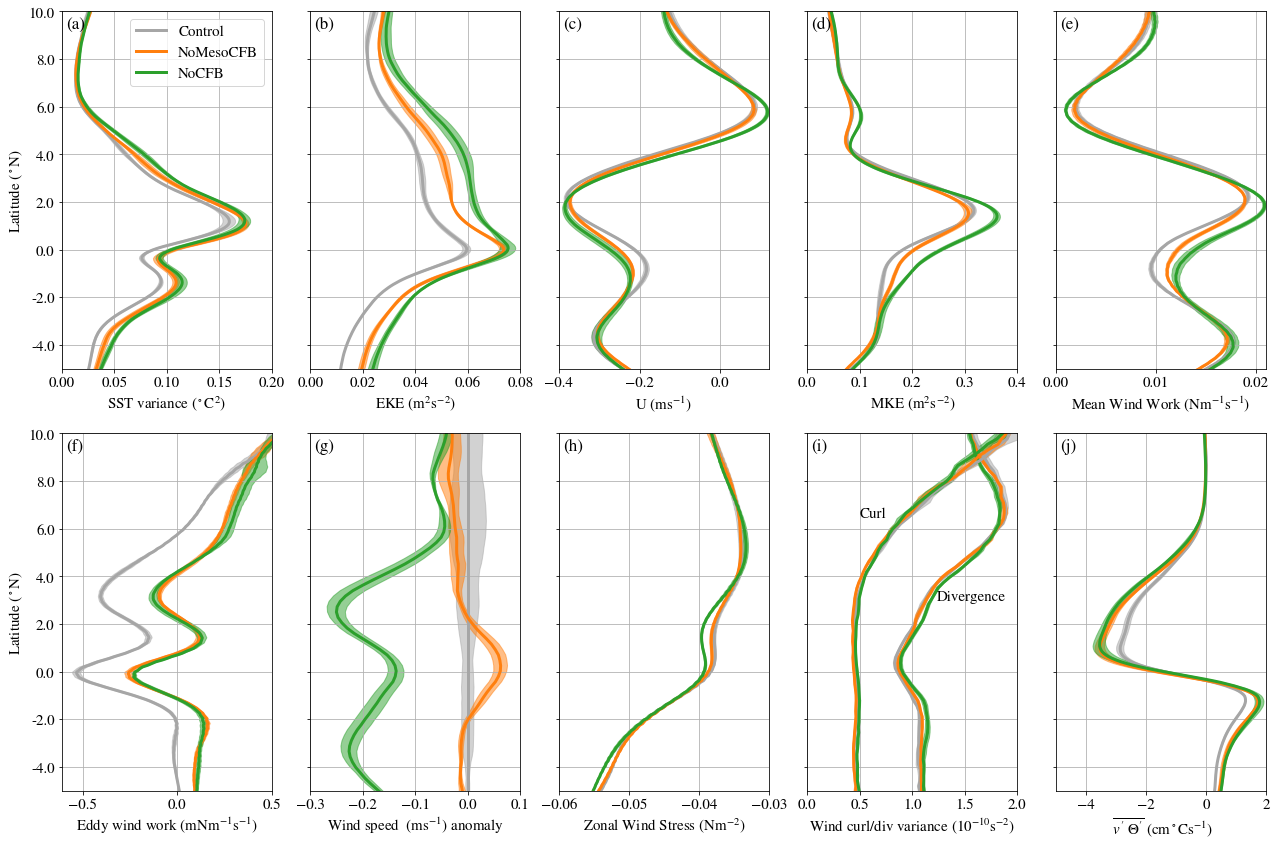

Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from 

In [36]:
# Latitude line plots (all ensembles):
#fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(15,12),facecolor='w')
fig, axes = plt.subplots(nrows=2,ncols=5,figsize=(18,12),facecolor='w')

axs = axes.flatten()

fix_xlims = True
cont = 'CROCO-WRF NoCFB'

runs = ['Control','NoMesoCFB','NoCFB']
cols = ['0.65','C1','C2']
labels = ['Control','NoMesoCFB','NoCFB']
varsd = [
        {'var':SSTvll,'label':'SST variance ($^\circ$C$^2$)','xlim':[0.,0.2],'yco':'y_rho','anom':False,'add_p':False},
#        {'var':GeWRFofll,'label':'Eddy air-sea APE flux (mWm$^{-2}$)','xlim':[-.5,.1],'yco':'y','anom':False,'add_p':False},
        {'var':EKEll,'label':'EKE (m$^2$s$^{-2}$)','xlim':[0.,0.08],'yco':'y_rho','anom':False,'add_p':False},
        {'var':Ull,'label':'U (ms$^{-1}$)','xlim':[-0.4,0.12],'yco':'y_u','anom':False,'add_p':False},
        {'var':MKEll,'label':'MKE (m$^2$s$^{-2}$)','xlim':[0.,0.4],'yco':'y_rho','anom':False,'add_p':False},
        {'var':MWWll,'label':'Mean Wind Work (Nm$^{-1}$s$^{-1}$)','xlim':[0.,0.021],'yco':'y_rho','anom':False,'add_p':False},   
        {'var':EWWll,'label':'Eddy wind work (mNm$^{-1}$s$^{-1}$)','xlim':[-6.1e-1,5.e-1],'yco':'y_rho','anom':False,'add_p':False},
        {'var':WSPDll,'label':'Wind speed  (ms$^{-1}$)','xlim':[-0.3,0.1],'yco':'y','anom':True,'add_p':False},
#        {'var':Wdivvll,'label':'Wind curl/div variance ($10^{-10}$s$^{-2}$)','xlim':[0.,20],'yco':'y_v','anom':False,'add_p':False},
        {'var':TAUUll,'label':'Zonal Wind Stress (Nm$^{-2}$)','xlim':[-60.e-3,-30.e-3],'yco':'y_u','anom':False,'add_p':False},
        {'var':Wdivvll,'label':'Wind curl/div variance ($10^{-10}$s$^{-2}$)','xlim':[0.,20],'yco':'y_v','anom':False,'add_p':False},
#        {'var':SSTll,'label':'SST  ($^\circ$C)','xlim':[-0.1,0.1],'yco':'y_rho','anom':True,'add_p':False},
        {'var':VSSTll,'label':' $\overline{v\'\,\,\Theta\'}$ (cm$^\circ$Cs$^{-1}$)','xlim':[-5,2],'yco':'y_rho','anom':False,'add_p':False}
        ]

for i,varss in enumerate(varsd):
    for j,run in enumerate(runs):
        for k in range(eL):
            ckey = 'CROCO-WRF ' + run
            key = ckey + '-E%01d' % (k+1)
            if varss['anom']:
                var = varss['var'][key]-varss['var'][cont]
                varc = varss['var'][ckey]-varss['var'][cont]
            else:
                var = varss['var'][key]
                varc = varss['var'][ckey]
#            var.plot(y=varss['yco'],ax=axs[i],color=cols[j],linewidth=0.5,alpha=0.75)
        varc.plot(y=varss['yco'],ax=axs[i],label=labels[j],color=cols[j],linewidth=3.)
        std = varss['var'][ckey + '-s']
        axs[i].fill_betweenx(std[varss['yco']],-zScore*std+varc,zScore*std+varc,color=cols[j],alpha=0.5)
    lab = varss['label']
    if varss['anom']: lab+= ' anomaly'        
    axs[i].set_xlabel(lab)
    if fix_xlims:
        axs[i].set_xlim(varss['xlim'])

# # Add extras:
# Wcur:
varss = {'var':Wcurvll,'label':'Wind curl/div variance ($10^{-10}$s$^{-2}$)','xlim':[0.,2],'yco':'y_v','anom':False,'add_p':False}
i = 8
for j,run in enumerate(runs):
    for k in range(eL):
        ckey = 'CROCO-WRF ' + run
        key = ckey + '-E%01d' % (k+1)
        if varss['anom']:
            var = varss['var'][key]-varss['var'][cont]
            varc = varss['var'][ckey]-varss['var'][cont]
        else:
            var = varss['var'][key]
            varc = varss['var'][ckey]
    varc.plot(y=varss['yco'],ax=axs[i],label=labels[j],color=cols[j],linewidth=3.)
    std = varss['var'][ckey + '-s']
    axs[i].fill_betweenx(std[varss['yco']],-zScore*std+varc,zScore*std+varc,color=cols[j],alpha=0.5)
lab = varss['label']
if varss['anom']: lab+= ' anomaly'        
axs[i].set_xlabel(lab)
if fix_xlims:
    axs[i].set_xlim(varss['xlim'])
axs[i].text(1.23,3.,'Divergence')
axs[i].text(.5,6.5,'Curl')

for ax in axs:
    ax.grid()
    ax.set_ylabel('')
    ax.set_yticklabels({})
    ax.set_title('')
for i, ax in enumerate(axs):
    ax.set_yticks(np.arange(-10.,20.,2.))
    ax.set_ylim([-5.,10.])
    xlims = ax.get_xlim()
    ax.text(xlims[0]+(xlims[1]-xlims[0])*0.02,9.3,letlab[i],fontsize=17)
axs[0].set_ylabel('Latitude ($^\circ$N)')
for ax in [axes[i][0] for i in range(np.shape(axes)[0])]:
    ax.set_ylabel('Latitude ($^\circ$N)')
    ax.set_yticklabels(np.arange(-10.,20.,2.))
axs[0].legend(loc='upper right')
#axs[7].legend(loc='upper left')
#axs[12].legend(loc='upper right')

plt.tight_layout()
plt.savefig('Production_Figures/NoCFB_latprofile_210to260_withWcurdivvSST.png',dpi=100)

# Production Values for a table averaged between +-5 degrees, 210-260E:

In [100]:
LONS = 210., 260.
LATS = -5., 5.

# Calculate area metrics in TIW region:
ds = data['CROCO-WRF Control-E3']['mon_TIWhp']
dA = (ds.pm)**(-1)*(ds.pn)**(-1)
rho_area = dA.sel(x_rho=slice(LONS[0],LONS[1])).sel(y_rho=slice(LATS[0],LATS[1]))
rho_area_tot = rho_area.sum('x_rho').sum('y_rho')
area_avg = False #True # This makes virtually no difference - don't bother.

#keys = ['CROCO-WRF Control',]#,'CROCO-WRF NoCFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFBr']
keys = ['CROCO-WRF Control','CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']#,'CROCO-WRF NoCFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFBr']

rho_vars = []#[SST,SSTv,EKE,EWW,MKE,MWW]#,VSST]
rho_labels = ['SST','SSTv','EKE','EWW','MKE','MWW']#,VSST]
uv_vars = []#[Wdivv,Wcurv]
uv_labels = ['Wdivv','Wcurv']
wrf_vars = [GeWRFofsmtew]#[WSPD,GeWRFof,GeWRFofsmt,GeWRFofsmtew]
wrf_labels = ['WSPD','GeWRFof','GWRFofsmt','GeWFTofsmtew']

labels = rho_labels + uv_labels + wrf_labels
for key in keys:
    for var in rho_vars:
        if area_avg:
            var[key]['boxavg'] = ((var[key].sel(x_rho=slice(LONS[0],LONS[1])).sel(y_rho=slice(LATS[0],LATS[1]))*rho_area).sum('x_rho').sum('y_rho')/rho_area_tot).load()
        else:
            var[key]['boxavg'] = var[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').sel(y_rho=slice(LATS[0],LATS[1])).mean('y_rho').load()
    for var in uv_vars:
        var[key]['boxavg'] = var[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').sel(y_v=slice(LATS[0],LATS[1])).mean('y_v').load()
    for var in wrf_vars:
        var[key]['boxavg'] = var[key].sel(x=slice(LONS[0],LONS[1])).mean('x').sel(y=slice(LATS[0],LATS[1])).mean('y').load()
vars = rho_vars + uv_vars + wrf_vars
for key in keys[1:]:
    for i, var in enumerate(vars):
        cont = var['CROCO-WRF Control']['boxavg']
        pert = var[key]['boxavg']
        print(key + ' ' + labels[i] + ' control: %3.3f, difference: %3.3f (%02d)' % (cont,pert-cont,(pert-cont)/cont*100))
#print('Ge fraction from atmospheric: %03d' % (GeWRFofsmt['CROCO-WRF Control']['boxavg']/GeWRFof['CROCO-WRF Control']['boxavg']*100))
#print('Ge fraction from atmospheric winds (Tair and Qair smoothed as well): %03d' % (GeWRFofsmtew['CROCO-WRF Control']['boxavg']/GeWRFof['CROCO-WRF Control']['boxavg']*100))

for i, var in enumerate(vars):
    cont = var['CROCO-WRF Control']['boxavg']
    string = labels[i] + ' control: %3.3f , ' % cont
    for key in keys[1:]:
        pert = var[key]['boxavg']
        string = string + key + ' difference: %3.3f (%1.0f), ' % (pert-cont,(pert-cont)/cont*100)
    print(string)

CROCO-WRF NoTFB SST control: -0.102, difference: 0.100 (-97)
CROCO-WRF NoMesoCFB SST control: -0.102, difference: -0.007 (07)
CROCO-WRF NoCFB SST control: -0.102, difference: -0.015 (15)
SST control: -0.102 , CROCO-WRF NoTFB difference: 0.100 (-97), CROCO-WRF NoMesoCFB difference: -0.007 (7), CROCO-WRF NoCFB difference: -0.015 (15), 


# 3D TIW-region EKE budget production terms analysis

In [65]:
# Calculate and average budget terms:
varst1 = ['uuUx','uvUy','uvVx','vvVy','uwUz','vwVz','wb']
varst2 = ['uu','vv']
varst = varst1 + varst2
EKEbud = {}
for var in varst:
    EKEbud[var] = {}
EKEbud['EKE'] = {}
EKEbud['EWW'] = {}
ds = data['CROCO-WRF Control-E3']['mon_TIWhp']
rho0 = ds['rho0']
    
# Restrict seasonally:
def is_season(month):
    return (month >= 1) & (month <= 12) # Full year
#    return (month >= 7) & (month <= 11)
#    return (month <= 2) | (month >= 12)  # DJF
#    return (month >= 7)                  # TIW season

keys = [x for x in expdict.keys() if expdict[x]['TIWoutput']]
for key in keys:
    
    # Wm-3 variables:
    for var in varst1:    
        print(key[:-3] + ' ' + var)
        EKEbud[var][key[:-3]] = -rho0*data[key]['mon_TIWhp'][var].sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    EKEbud['wb'][key[:-3]] = -EKEbud['wb'][key[:-3]]
    
    # GJm-3 variables (just EKE):
    for var in varst2:    
        print(key[:-3] + ' ' + var)
        EKEbud[var][key[:-3]] = data[key]['mon_TIWhp'][var].sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    EKEbud['EKE'][key[:-3]] = 1.e-9*0.5*rho0*(EKEbud['uu'][key[:-3]] + EKEbud['vv'][key[:-3]])
    
    # Eddy wind work:
    EWWu = data[key]['mon_hp'].EWWU.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    EWWv = data[key]['mon_hp'].EWWV.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    EKEbud['EWW'][key[:-3]] = grid.interp(EWWu,'x',boundary='fill').rename({'y_u':'y_rho'})+grid.interp(EWWv,'y',boundary='fill').rename({'x_v':'x_rho'})
    
varst = varst[:-2] + ['EKE']

CROCO-WRF Control uuUx
CROCO-WRF Control uvUy
CROCO-WRF Control uvVx
CROCO-WRF Control vvVy
CROCO-WRF Control uwUz
CROCO-WRF Control vwVz
CROCO-WRF Control wb
CROCO-WRF Control uu
CROCO-WRF Control vv
CROCO-WRF NoTFB uuUx
CROCO-WRF NoTFB uvUy
CROCO-WRF NoTFB uvVx
CROCO-WRF NoTFB vvVy
CROCO-WRF NoTFB uwUz
CROCO-WRF NoTFB vwVz
CROCO-WRF NoTFB wb
CROCO-WRF NoTFB uu
CROCO-WRF NoTFB vv
CROCO-WRF NoMesoCFB uuUx
CROCO-WRF NoMesoCFB uvUy
CROCO-WRF NoMesoCFB uvVx
CROCO-WRF NoMesoCFB vvVy
CROCO-WRF NoMesoCFB uwUz
CROCO-WRF NoMesoCFB vwVz
CROCO-WRF NoMesoCFB wb
CROCO-WRF NoMesoCFB uu
CROCO-WRF NoMesoCFB vv
CROCO-WRF NoCFB uuUx
CROCO-WRF NoCFB uvUy
CROCO-WRF NoCFB uvVx
CROCO-WRF NoCFB vvVy
CROCO-WRF NoCFB uwUz
CROCO-WRF NoCFB vwVz
CROCO-WRF NoCFB wb
CROCO-WRF NoCFB uu
CROCO-WRF NoCFB vv


In [66]:
# Calculate grid cell metrics in TIW region:
# XXX: Would be better to use xgcm for this instead...!!
#
ds = data['CROCO-WRF Control-E3']['mon_TIWhp']
L1, M1 = int(ds.L1.values), int(ds.M1.values)
[Mm,Lm] = ds.h.shape
z_r, z_w = ftools.zlevs(ds.h,data['CROCO-WRF Control-E3']['mon'].zeta.isel(x_rho=slice(L1,L1+Lm),y_rho=slice(M1,M1+Mm)).isel(time=0),ds.hc.values,ds.Cs_r.values,grd.Cs_w.values)
dz = xr.zeros_like(ds.uuUx.isel(time=0))
dz.data = np.transpose(z_w[:,:,1:]-z_w[:,:,:-1],(2,0,1))
dx = (ds.pm)**(-1)
dy = (ds.pn)**(-1)
dV = dx*dy*dz

# Extract vertical coordinate for plotting and choosing maximum depth:
z = xr.zeros_like(data['CROCO-WRF Control-E3']['mon_TIWhp'].uuUx.isel(time=0)).rename('z_rho')
z.values = np.transpose(z_r,(2,0,1))

In [69]:
# Calculate totals:
lons = 210.,260. # Longitude range
lats = -5., 5.   # Latitude range
zb = -150.       # Maximum depth

zl = z.sel(x_rho=slice(lons[0],lons[1])).mean('x_rho',skipna=True)
zb_ind = abs(zl.sel(y_rho=0.,method='nearest')-zb).argmin('s_rho')

keys = [x for x in expdict.keys() if expdict[x]['TIWoutput']]
totals = {}
for var in varst:
    totals[var] = {}
    for key in keys:
        totals[var][key[:-3]] = float((dV*EKEbud[var][key[:-3]]).sel(x_rho=slice(lons[0],lons[1])).sel(y_rho=slice(lats[0],lats[1])).isel(s_rho=slice(zb_ind.values,None)).sum('x_rho').sum('y_rho').sum('s_rho'))
        # Adjust units:
        totals[var][key[:-3]] = totals[var][key[:-3]]*1.e-9 # GW
# Correct units for EKE and do EWW:
totals['EWW'] = {}
for key in keys:
    totals['EKE'][key[:-3]] = totals['EKE'][key[:-3]]*1.e3 # PJ

    totals['EWW'][key[:-3]] = float((dx*dy*EKEbud['EWW'][key[:-3]]).sel(x_rho=slice(lons[0],lons[1])).sel(y_rho=slice(lats[0],lats[1])).sum('x_rho').sum('y_rho'))*1.e-9

# Add anomalies from Control and percentages:
keys = ['CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
for var in totals.keys():
    for key in keys:
        totals[var][key + ' anomaly'] = totals[var][key] - totals[var]['CROCO-WRF Control']
        totals[var][key + ' anomaly perc'] = 100*(totals[var][key] - totals[var]['CROCO-WRF Control'])/totals[var]['CROCO-WRF Control']

In [70]:
# Print nicely:
for var in (totals.keys()):
    string = var.ljust(5) + ': ' + ''.join([lab + ' % 6.2f' % (value) + ' ' for lab, value in totals[var].items()]) + ' '
    print(string)

uuUx : CROCO-WRF Control  -0.13 CROCO-WRF NoTFB  -0.12 CROCO-WRF NoMesoCFB  -0.19 CROCO-WRF NoCFB  -0.17 CROCO-WRF NoTFB anomaly   0.01 CROCO-WRF NoTFB anomaly perc -10.42 CROCO-WRF NoMesoCFB anomaly  -0.06 CROCO-WRF NoMesoCFB anomaly perc  45.73 CROCO-WRF NoCFB anomaly  -0.04 CROCO-WRF NoCFB anomaly perc  30.47  
uvUy : CROCO-WRF Control   3.00 CROCO-WRF NoTFB   2.92 CROCO-WRF NoMesoCFB   3.00 CROCO-WRF NoCFB   3.54 CROCO-WRF NoTFB anomaly  -0.07 CROCO-WRF NoTFB anomaly perc  -2.48 CROCO-WRF NoMesoCFB anomaly   0.00 CROCO-WRF NoMesoCFB anomaly perc   0.12 CROCO-WRF NoCFB anomaly   0.54 CROCO-WRF NoCFB anomaly perc  18.05  
uvVx : CROCO-WRF Control  -0.02 CROCO-WRF NoTFB  -0.02 CROCO-WRF NoMesoCFB  -0.02 CROCO-WRF NoCFB  -0.04 CROCO-WRF NoTFB anomaly   0.00 CROCO-WRF NoTFB anomaly perc  -2.98 CROCO-WRF NoMesoCFB anomaly   0.01 CROCO-WRF NoMesoCFB anomaly perc -31.56 CROCO-WRF NoCFB anomaly  -0.02 CROCO-WRF NoCFB anomaly perc  79.05  
vvVy : CROCO-WRF Control  -0.08 CROCO-WRF NoTFB  -0.

In [84]:
# Plot latitude-depth slices:
cont = 'CROCO-WRF Control'

# NoTFB:
al = 35
ass = 2.5
EKEal = np.arange(-0.02,0.022,0.002)

# NoCFB:
al = 40
ass = 2.5
EKEal = np.arange(-0.05,0.052,0.002)

varl = [
       {'var':'EKE','label':r'$0.5\rho_0(\overline{u\prime u \prime+v\prime v\prime})$','unit':'GJm$^{-2}$','mclim':np.arange(0,.17,0.01),'aclim':EKEal,'cmap':cm.cm.amp},
       {'var':'uvUy','label':r'$-\rho_0 \overline{u\prime v\prime} U_y$','unit':'Wm$^{-2}$','mclim':np.arange(-200,220,20),'aclim':np.arange(-al,al+ass,ass),'cmap':'RdBu_r'},
       {'var':'wb','label':r'$\rho_0 \overline{w\prime b\prime}$','unit':'Wm$^{-2}$','mclim':np.arange(-200,220,20),'aclim':np.arange(-al,al+ass,ass),'cmap':'RdBu_r'},
#       {'var':'uuUx','label':r'$-\rho_0\overline{u\prime u\prime} U_x$','unit':'Wm$^{-2}$','mclim':np.arange(-100,110,10),'aclim':np.arange(-al,al+ass,ass),'cmap':'RdBu_r'},
#       {'var':'uvVx','label':r'$-\rho_0\overline{u\prime v\prime} V_x$','unit':'Wm$^{-2}$','mclim':np.arange(-100,110,10),'aclim':np.arange(-al,al+ass,ass),'cmap':'RdBu_r'},
       {'var':'vvVy','label':r'$-\rho_0 \overline{v\prime v\prime} V_y$','unit':'Wm$^{-2}$','mclim':np.arange(-100,110,10),'aclim':np.arange(-al,al+ass,ass),'cmap':'RdBu_r'},
       {'var':'uwUz','label':r'$-\rho_0 \overline{u\prime w\prime} U_z$','unit':'Wm$^{-2}$','mclim':np.arange(-100,110,10),'aclim':np.arange(-al,al+ass,ass),'cmap':'RdBu_r'},
       {'var':'vwVz','label':r'$-\rho_ \overline{v\prime w\prime} V_z$','unit':'Wm$^{-2}$','mclim':np.arange(-100,110,10),'aclim':np.arange(-al,al+ass,ass),'cmap':'RdBu_r'},
]

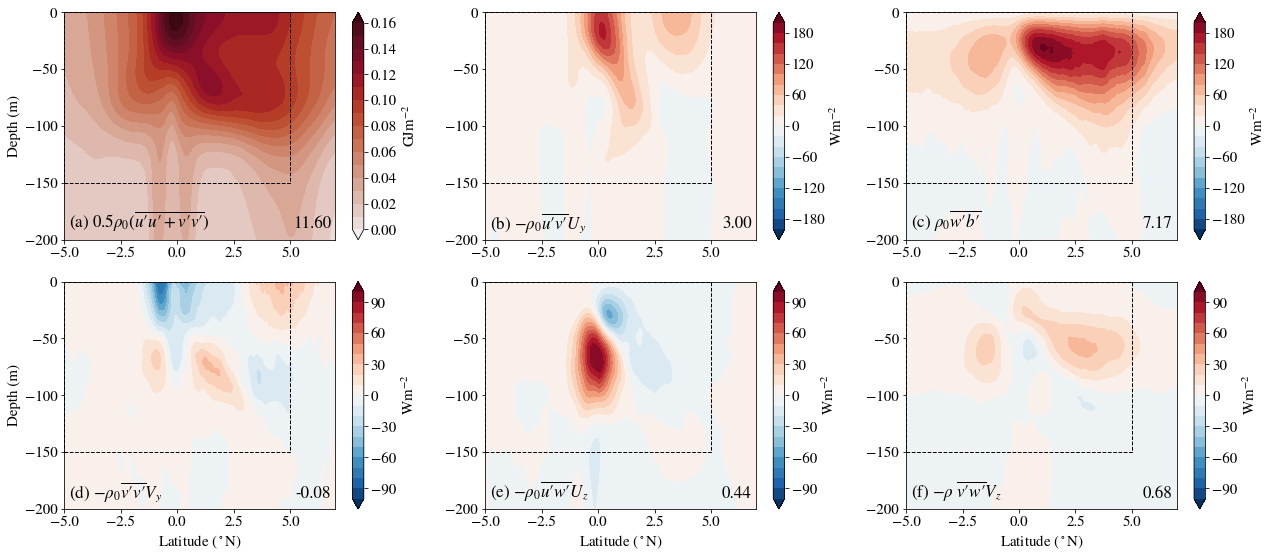

In [77]:
# Longitude average control:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(18,8),facecolor='w')
axs = axes.flatten()
for i,var in enumerate(varl):
    vart = (EKEbud[var['var']][cont]*dx).sel(x_rho=slice(lons[0],lons[1])).sum('x_rho').assign_coords(zl=zl)
    vart.zl.values = vart.zl.fillna(0.).values
    vart.plot.contourf(ax=axs[i],y='zl',levels=var['mclim'],cmap=var['cmap'],extend='both',cbar_kwargs={'label':var['unit']})
    
    # Add total and box:
    axs[i].plot([lats[0],lats[1],lats[1],lats[0],lats[0]],[zb,zb,0,0,zb],'--k',linewidth=1)
    axs[i].text(6.8,-190.,'%3.2f' % (totals[var['var']][cont]),horizontalalignment='right',fontsize=17)
    axs[i].set_facecolor('k')
    axs[i].set_ylim([-200.,0.])
    axs[i].set_xlim([-5.005,7.])
    axs[i].text(-4.8,-190,letlab[i] + ' ' + var['label'],fontsize=17)
    axs[i].set_title('')
    #axs[i].set_title(letlab[i] + ' ' + var['label'],fontsize=17)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

for axs in [axes[0][0],axes[1][0]]:
    axs.set_ylabel('Depth (m)')
for axs in axes[1]:
    axs.set_xlabel('Latitude ($^\circ$N)')
plt.tight_layout()
plt.savefig('Production_Figures/Control_EKE_Budget_210to260.png',dpi=100)

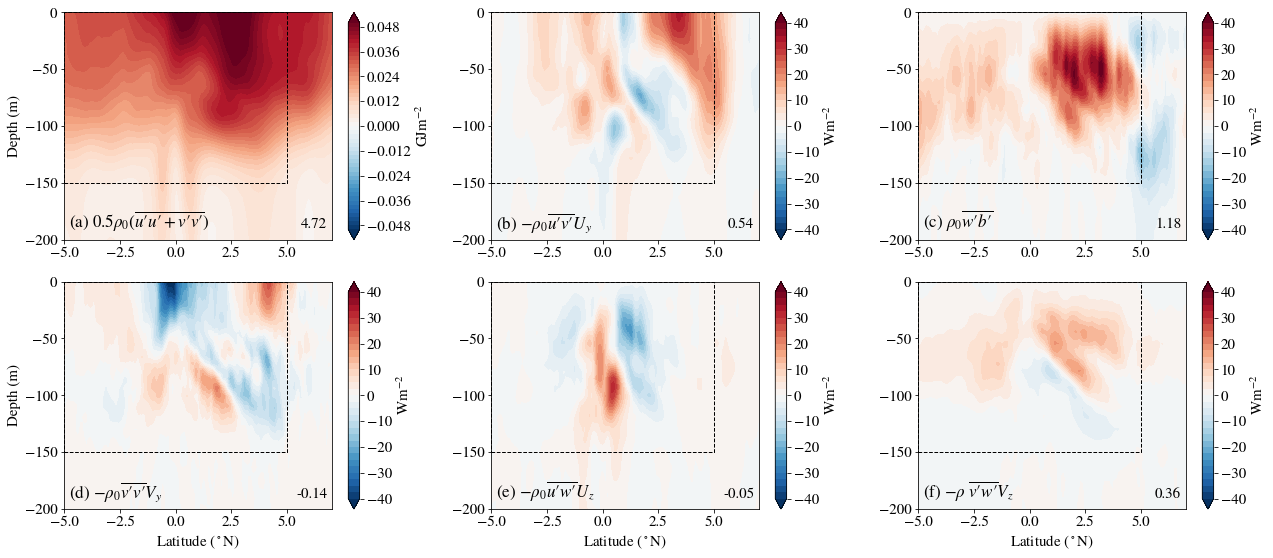

In [86]:
# Depth average perturbation:
key = 'CROCO-WRF NoCFB'

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(18,8),facecolor='w')
axs = axes.flatten()
for i,var in enumerate(varl):
    vart = ((EKEbud[var['var']][key]-EKEbud[var['var']][cont])*dx).sel(x_rho=slice(lons[0],lons[1])).sum('x_rho').assign_coords(zl=zl)
    vart.zl.values = vart.zl.fillna(0.).values
    vart.plot.contourf(ax=axs[i],y='zl',levels=var['aclim'],cmap='RdBu_r',extend='both',cbar_kwargs={'label':var['unit']})
    
    # Add total and box:
    axs[i].plot([lats[0],lats[1],lats[1],lats[0],lats[0]],[zb,zb,0,0,zb],'--k',linewidth=1)
    axs[i].text(6.8,-190.,'%3.2f' % (totals[var['var']][key]-totals[var['var']][cont]),
        horizontalalignment='right')
    axs[i].set_facecolor('k')
    axs[i].set_ylim([-200.,0.])
    axs[i].set_xlim([-5.005,7.])
    axs[i].set_title('')
    axs[i].text(-4.8,-190,letlab[i] + ' ' + var['label'],fontsize=17)
    #axs[i].set_title(letlab[i] + ' ' + var['label'],fontsize=17)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

for axs in [axes[0][0],axes[1][0]]:
    axs.set_ylabel('Depth (m)')
for axs in axes[1]:
    axs.set_xlabel('Latitude ($^\circ$N)')
plt.tight_layout()
plt.savefig('Production_Figures/NoCFB_EKE_Budget_210to260.png',dpi=100)

# # Depth average perturbation:
# for key in keys:
#     fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(20,10),facecolor='w')
#     axs = axes.flatten()
#     for i,var in enumerate(varl):
#         vart = ((EKEbud[var['var']][key]-EKEbud[var['var']][cont])*dx).sel(x_rho=slice(lons[0],lons[1])).sum('x_rho').assign_coords(zl=zl)
#         vart.zl.values = vart.zl.fillna(0.).values
#         vart.plot(ax=axs[i],y='zl',vmin=var['aclim'][0],vmax=var['aclim'][1],cmap='RdBu_r',extend='both')
#         axs[i].set_title(key + ' - Control ' + var['label'])
        
#         # Add total:
#         axs[i].text(6.,-230.,'%3.2f (%d)' % (totals[var['var']][key]-totals[var['var']][cont],(totals[var['var']][key]-totals[var['var']][cont])/totals[var['var']][cont]*100.))
    
#     for axs in axes.flatten():
#         axs.set_facecolor('k')
#         axs.set_ylim([-250.,0.])
#         axs.set_label('Depth (m)')
#     plt.tight_layout()
#    plt.savefig('Budgets/' + key.replace(' ','_') + '_EKE_Budget_210to260_JASOND.png',dpi=100)

In [ ]:
# Plot Depth:
keys = ['CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
cont = 'CROCO-WRF Control'
varl = [
       {'var':'uuUx','label':'-\overline{u\'u\'}U_x [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':'uvUy','label':'-\overline{u\'v\'}U_y [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':'uvVx','label':'-\overline{u\'v\'}V_x [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':'vvVy','label':'-\overline{v\'v\'}V_y [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':'uwUz','label':'-\overline{u\'w\'}U_z [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':'vwVz','label':'-\overline{v\'w\'}V_z [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':'wb','label':'\overline{w\'b\'} [m2s-3]','mclim':[-5.e-8,5.e-8],'aclim':[-5.e-9,5.e-9],'cmap':'RdBu_r'},
]

slims = 10,-1

# Depth average control:
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(30,20),facecolor='w')
axs = axes.flatten()
for i,var in enumerate(varl):
     EKEbud[var['var']][cont].isel(s_rho=slice(slims[0],slims[1])).mean('s_rho').plot(ax=axs[i],vmin=var['mclim'][0],vmax=var['mclim'][1],cmap=var['cmap'],extend='both')
    axs[i].set_title(cont + ' ' + var['label'])
axs[7].axis('off')
axs[8].axis('off')
for axs in axes.flatten():
    axs.set_facecolor('k')
plt.tight_layout()
#plt.savefig(fn,dpi=100)

# Depth average perturbation:
for key in keys:
    fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(30,20),facecolor='w')
    axs = axes.flatten()
    for i,var in enumerate(varl):
        (EKEbud[var['var']][key]-EKEbud[var['var']][cont]).isel(s_rho=slice(slims[0],slims[1])).mean('s_rho').plot(ax=axs[i],vmin=var['aclim'][0],vmax=var['aclim'][1],cmap=var['cmap'],extend='both')
        axs[i].set_title(key + ' ' + var['label'])
    axs[7].axis('off')
    axs[8].axis('off')
    for axs in axes.flatten():
        axs.set_facecolor('k')
    plt.tight_layout()
#plt.savefig(fn,dpi=100)

# Atmospheric anomalies - zonal average latitude-pressure plots

In [12]:
# Mean state variables:
T = {};U = {};V = {};PBLH={}#W = {};

lons = 210.,260.

# Restrict seasonally:
def is_season(month):
    return (month >= 1) & (month <= 12) # Full year
#    return (month >= 7) & (month <= 11)
#    return (month <= 2) | (month >= 12)  # DJF
#    return (month >= 7)                  # TIW season
def season_res(ds):
    ds = ds.sel(time=is_season(ds['time.month']))
    if len(ds.time) != 48:
        print('%03d' % (len(ds.time)) + ' != 48 for ' + ds.name)
    return(ds)

keys = expdict.keys()
for key in keys:
    print(key)
    T[key] = season_res(data[key]['wrf_day4d'].T.sel(x_grid_M=slice(lons[0],lons[1])).mean('x_grid_M')).mean('time').load()
    U[key] = season_res(data[key]['wrf_day4d'].U.sel(x_grid_U=slice(lons[0],lons[1])).mean('x_grid_U')).mean('time').load()
    V[key] = season_res(data[key]['wrf_day4d'].V.sel(x_grid_V=slice(lons[0],lons[1])).mean('x_grid_V')).mean('time').load()
    PBLH[key] = season_res(data[key]['wrf_day'].PBLH.sel(x=slice(lons[0],lons[1])).mean('x')).mean('time').load()
   # W[key] = data[key]['wrf_day4d'].W.sel(x_grid_M=slice(lons[0],lons[1])).mean('x_grid_M').sel(time=is_season(data[key]['wrf_day4d']["time.month"])).mean('time').load()

CROCO-WRF Control-E1
1461 != 48 for T
1461 != 48 for U
1461 != 48 for V
1461 != 48 for PBLH
CROCO-WRF Control-E2
1461 != 48 for T
1461 != 48 for U
1461 != 48 for V
1461 != 48 for PBLH
CROCO-WRF Control-E3
1461 != 48 for T
1461 != 48 for U
1461 != 48 for V
1461 != 48 for PBLH
CROCO-WRF Control-E4
1461 != 48 for T
1461 != 48 for U
1461 != 48 for V
1461 != 48 for PBLH
CROCO-WRF Control-E5
1461 != 48 for T
1461 != 48 for U
1461 != 48 for V
1461 != 48 for PBLH
CROCO-WRF NoTFB-E1
1461 != 48 for T
1461 != 48 for U
1461 != 48 for V
1461 != 48 for PBLH
CROCO-WRF NoTFB-E2
1461 != 48 for T
1461 != 48 for U
1461 != 48 for V
1461 != 48 for PBLH
CROCO-WRF NoTFB-E3
1461 != 48 for T
1461 != 48 for U
1461 != 48 for V
1461 != 48 for PBLH
CROCO-WRF NoTFB-E4
1461 != 48 for T
1461 != 48 for U
1461 != 48 for V
1461 != 48 for PBLH
CROCO-WRF NoTFB-E5
1461 != 48 for T
1461 != 48 for U
1461 != 48 for V
1461 != 48 for PBLH
CROCO-WRF NoMesoCFB-E1
1461 != 48 for T
1461 != 48 for U
1461 != 48 for V
1461 != 48 for P

In [13]:
# Calculate ensembles:
lst = [T,U,V,PBLH]
runs = ['Control','NoTFB','NoMesoCFB','NoCFB']
for obj in lst:
    for run in runs:
        obj['CROCO-WRF ' + run] = obj['CROCO-WRF ' + run + '-E1'].copy()
        for ei in range(eL-1):
            obj['CROCO-WRF ' + run] += obj['CROCO-WRF ' + run + '-E%01d' % (ei+2)]
        obj['CROCO-WRF ' + run] = obj['CROCO-WRF ' + run]/eL
cont = 'CROCO-WRF Control'

In [14]:
# Calculate significance levels for perturbations:
typ = 'Welch'
### Option 1: Z score on Control ensemble:
if (typ == 'ConZ'):
    zScore = 2.58 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)
    for obj in lst:

        # Calculate standard deviation:
        std = np.zeros_like(obj['CROCO-WRF Control-E1'])
        for e in range(eL):
            std += (obj['CROCO-WRF Control-E%01d' % (e+1)]-obj['CROCO-WRF Control'])**2.
        std = np.sqrt(std/eL)

        for key in keys:
            obj[key + '-s'] = xr.zeros_like(obj[key])
            obj[key + '-s'].values = np.where(abs(obj[key].values-obj['CROCO-WRF Control'])>(zScore*std),1.,0.)

### Option 2: Instead use outside range of ensemble members:
elif (typ == 'ConR'):    # 
    yL, xL = np.shape(obj['CROCO-WRF Control-E1'].values)
    tmp = np.zeros((yL,xL,eL))
    for e in range(eL):
        tmp[:,:,e] = obj[pert].values - obj['CROCO-WRF Control-E%01d' % (e+1)].values

    obj[key + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
    obj[key + '-s'].values = np.logical_or(np.all(tmp>0.,axis=2),np.all(tmp<0.,axis=2))
    
### Option 3: Welch's t-test (https://en.wikipedia.org/wiki/Welch%27s_t-test) on two distributions:
elif (typ == 'Welch'):
    critp = 0.05  # critical p-value
    zScore = 2.58 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)
    for obj in lst:

        # Calculate standard deviations:
        std = {}
        for run in runs:
            std[run] = np.zeros_like(obj['CROCO-WRF Control-E1'])
            for e in range(eL):
                std[run] += (obj['CROCO-WRF ' + run + '-E%01d' % (e+1)]-obj['CROCO-WRF ' + run])**2.
            std[run] = np.sqrt(std[run]/(eL-1)) # Corrected sample standard deviation https://en.wikipedia.org/wiki/Standard_deviation#Corrected_sample_standard_deviation

        # Calculate t and degrees-of-freedom:
        t = {}
        nu = {}
        for run in runs:
            s1 = std[run]/np.sqrt(eL)
            s2 = std['Control']/np.sqrt(eL)
            sd = np.sqrt(s1**2.+s2**2.)
            t[run] = (obj['CROCO-WRF ' + run] - obj['CROCO-WRF Control'])/sd
            nu[run] = (eL-1)*sd**4./(s1**4.+s2**4.)
        
        # Calculate p-value
        p = {}
        for run in runs:
            p[run] = stats.t.sf(np.abs(t[run]), nu[run]-1)*2
            obj['CROCO-WRF ' + run + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
            obj['CROCO-WRF ' + run + '-s'].values = np.where(p[run]<critp,1.,0.)

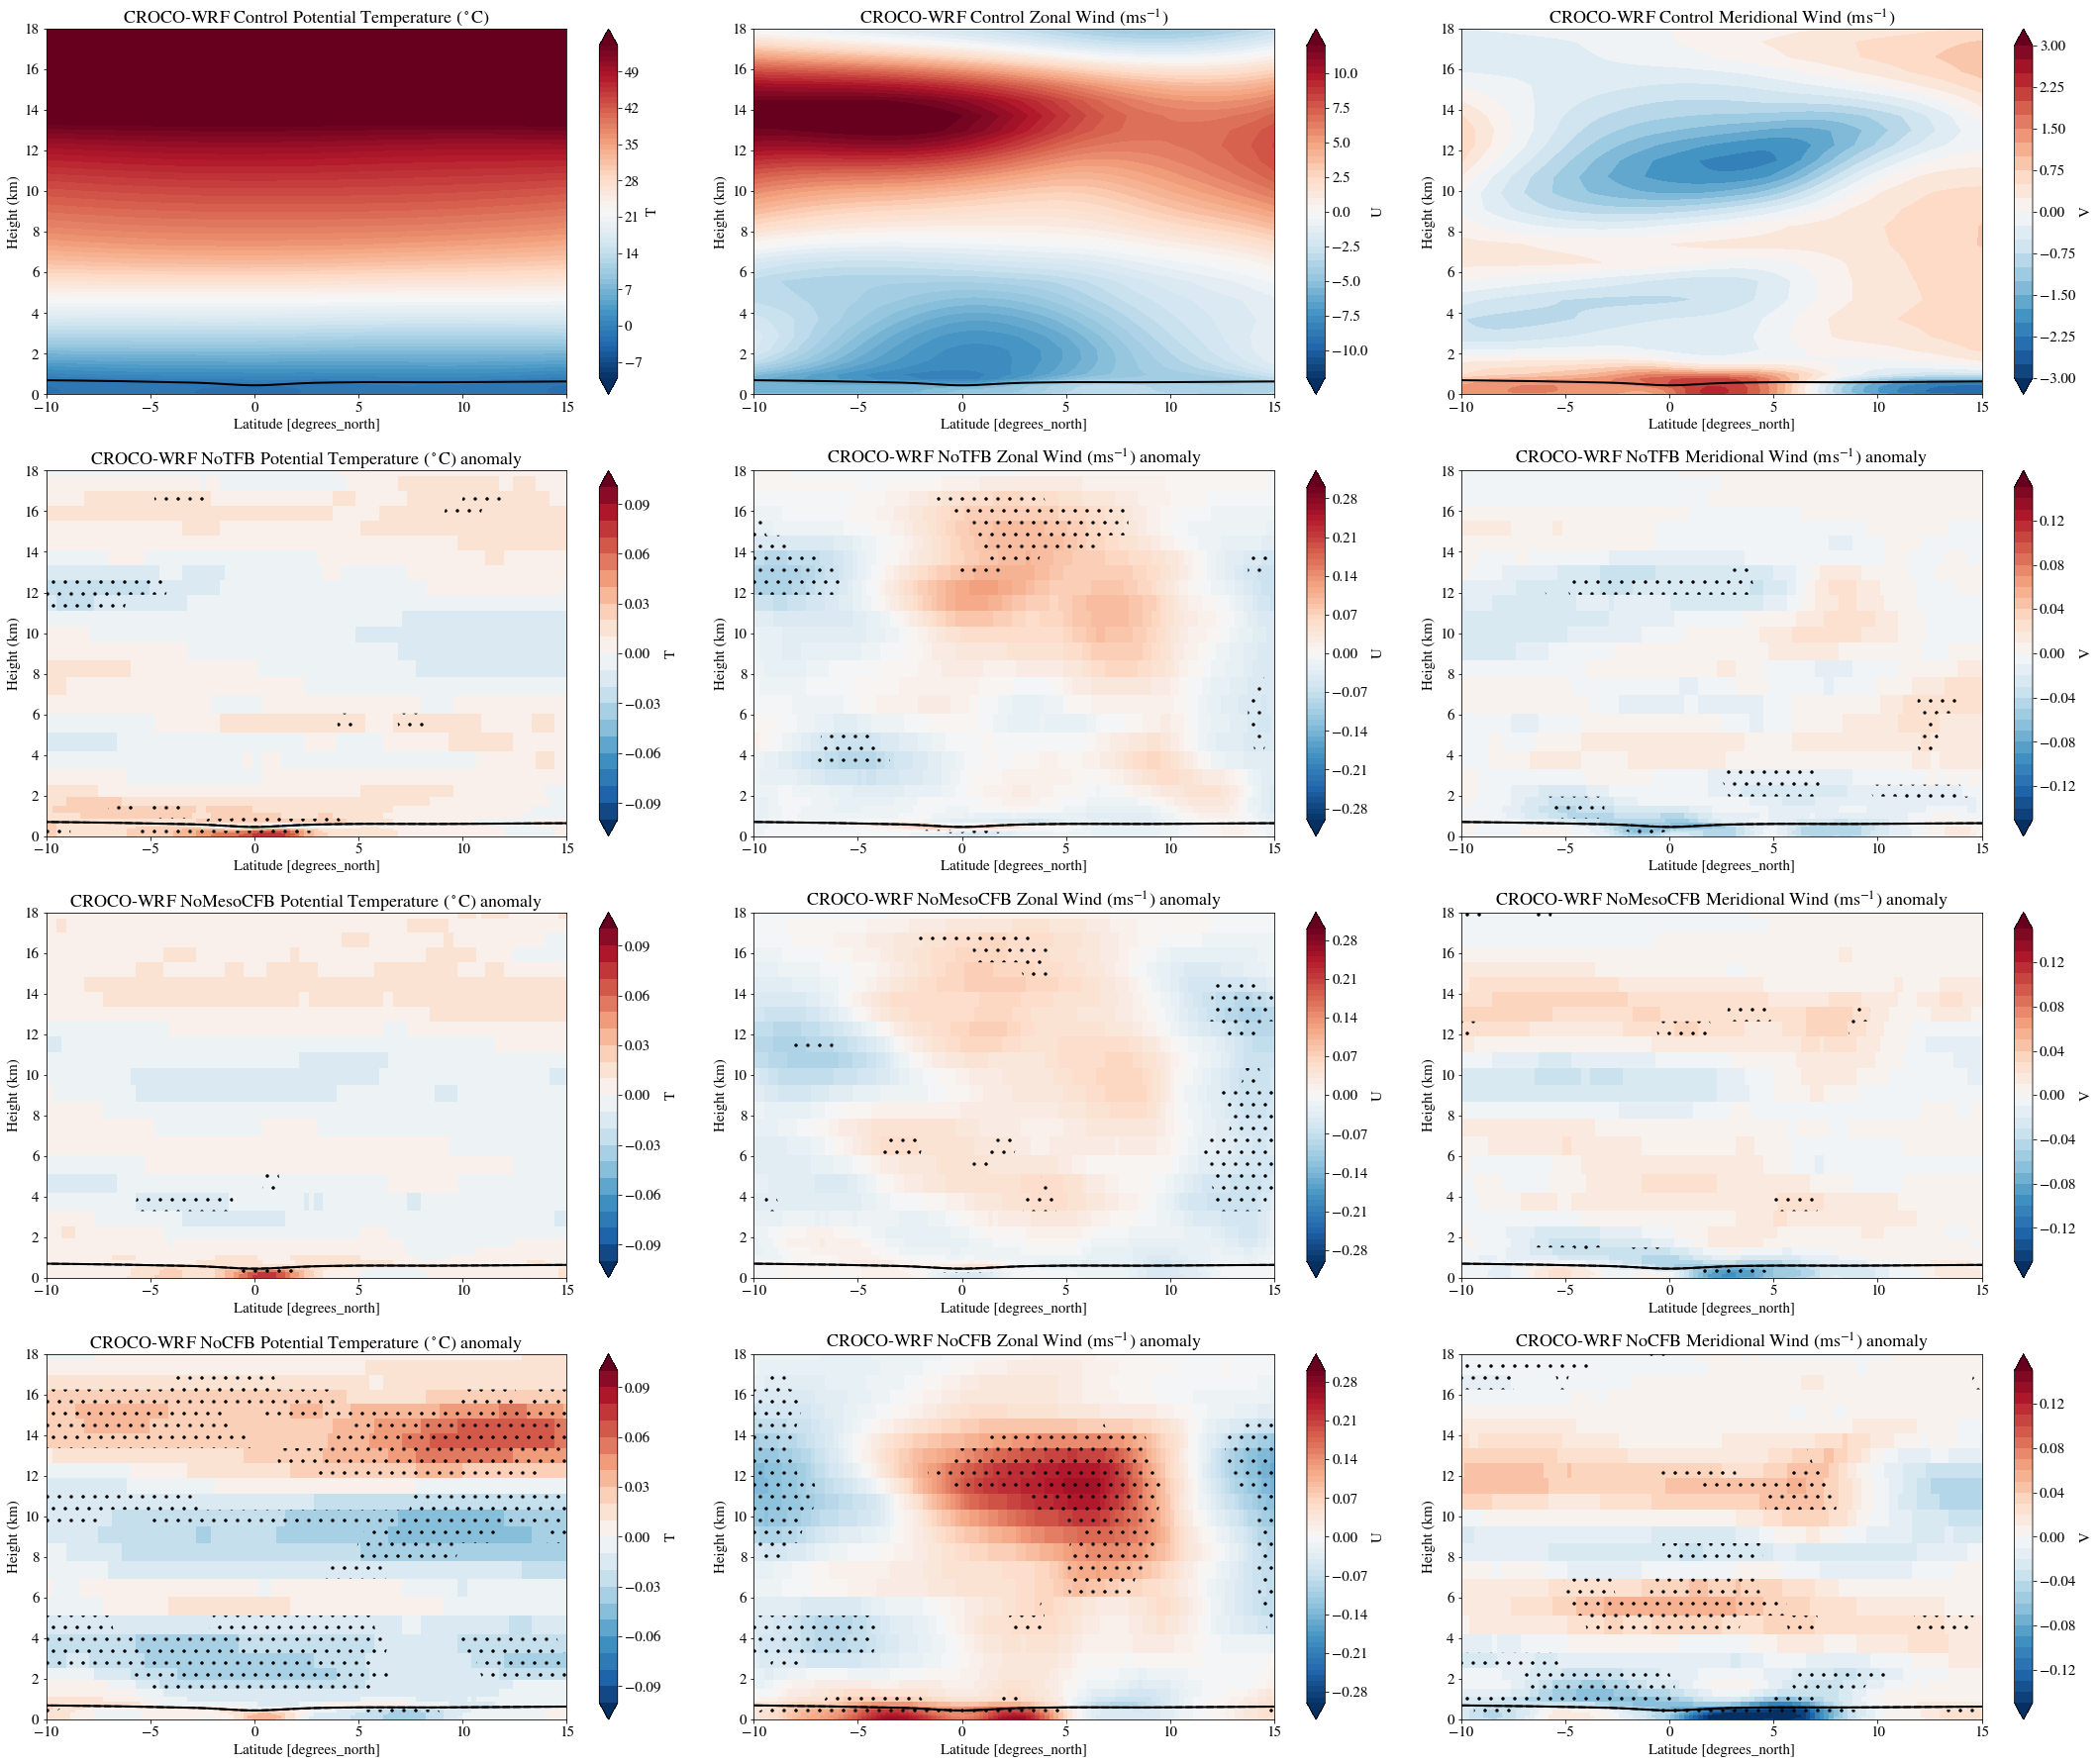

In [21]:
hatch_sig = True
keys = ['CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']#,'CROCO-WRF PP81']
varla = [
     # T, U, S:
     #{'varl':[{'var':T,'label':'Temperature ($^\circ$C)','mclim':[-50.,100.],'aclim':[-0.1,.1],'cmap':'RdBu_r','y_co':'lev_M'},
     #   {'var':U,'label':'Zonal Wind (ms$^{-1}$)','mclim':[-15,15],'aclim':[-0.25,.25],'cmap':'RdBu_r','y_co':'lev_M'},
     #   {'var':V,'label':'Meridional Wind (ms$^{-1}$)','mclim':[-3,3],'aclim':[-0.15,.15],'cmap':'RdBu_r','y_co':'lev_M'}
     {'varl':[{'var':T,'label':'Potential Temperature ($^\circ$C)','mclim':np.arange(-10.,55.,1.),'aclim':np.arange(-0.1,.11,0.01),'cmap':'RdBu_r','y_co':'lev_M'},
        {'var':U,'label':'Zonal Wind (ms$^{-1}$)','mclim':np.arange(-12,12.5,.5),'aclim':np.arange(-0.3,.31,0.01),'cmap':'RdBu_r','y_co':'lev_M'},
        {'var':V,'label':'Meridional Wind (ms$^{-1}$)','mclim':np.arange(-3,3.25,.25),'aclim':np.arange(-0.15,.16,0.01),'cmap':'RdBu_r','y_co':'lev_M'}
             ],
     'fname':'Atmosphere/TUV_onz_210to260_All.png'},
]

for j,vard in enumerate(varla):
    varl = vard['varl']
    
    fig, axes = plt.subplots(nrows=len(keys)+1,ncols=3,figsize=(30,(25/4)*(len(keys)+1)),facecolor='w')
    axs = axes.flatten()
    
    for i,var in enumerate(varl):
        #var['var'][cont].plot.contourf(ax=axs[i],y='Z',vmin=var['mclim'][0],vmax=var['mclim'][1],cmap=var['cmap'],extend='both')
        var['var'][cont].plot.contourf(ax=axs[i],y='Z',levels=var['mclim'],cmap=var['cmap'],extend='both')
        (PBLH[cont]/1.e3).plot(ax=axs[i],color='k')
        axes[0][i].set_title(cont + ' ' + var['label'])

    for i, key in enumerate(keys):
        for j, var in enumerate(varl):
            #(var['var'][key]-var['var'][cont]).plot(ax=axes[i+1][j],y='Z',vmin=var['aclim'][0],vmax=var['aclim'][1],cmap='RdBu_r',extend='both')
            (var['var'][key]-var['var'][cont]).plot(ax=axes[i+1][j],y='Z',levels=var['aclim'],cmap='RdBu_r',extend='both')
            (PBLH[cont]/1.e3).plot(ax=axes[i+1][j],color='k')
            (PBLH[key]/1.e3).plot(ax=axes[i+1][j],color='k',linestyle='dashed')
            try: 
                if hatch_sig:  var['var'][key+'-s'].plot.contourf(ax=axes[i+1][j],y='Z',levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
            except:
                pass
            axes[i+1][j].set_title(key + ' ' + var['label'] + ' anomaly')

    for axs in axes.flatten():
        axs.set_facecolor('k')
        axs.set_ylim([0.,18.])
        axs.set_xlim([-10.,15.])
        axs.set_ylabel('Height (km)')
    plt.tight_layout()
    fn = vard['fname']
    if (len(fn)>1): plt.savefig(fn,dpi=100)